In [1]:
import pandas as pd

import pickle
import numpy as np

import requests
from concurrent.futures import ThreadPoolExecutor, as_completed

from unidecode import unidecode

***
***

## API CEP -> endereço
Confirma somente que a rua está relacionada com o CEP (não checa número -> verificador do CEP)

In [2]:
dfs = []
for i in range(1,7):
    df_aux = pd.DataFrame(columns = ['Logradouro', 'Complemento'])
    df_aux.loc[-1] = ['a', 'a']

    with open(f'results/cep_batch_{i}.pkl', 'rb') as file:
        loaded = pickle.load(file)
    
    for k, v in loaded.items():
        df_aux.loc[k] = [str(d) for d in v.tolist()]
    
    # Replace '' with NaN in the specified columns
    df_aux[['Logradouro', 'Complemento']] = df_aux[['Logradouro', 'Complemento']].replace('', np.nan)
    
    # df_aux = df_aux.dropna(how = 'all')

    df_aux.drop(-1, inplace = True)
    
    dfs.append(df_aux)
    
df_cep = pd.concat(dfs)

df_cep = df_cep.reset_index().rename(columns = {'index' : 'CEP'})
df_cep['CEP'] = df_cep['CEP'].astype(str)


df_cep = df_cep.sort_values(by='Logradouro', na_position='last')
df_cep = df_cep.drop_duplicates(subset='CEP', keep='first')

df_cep['Status'] = df_cep[['Logradouro', 'Complemento']].notnull().any(axis = 1)


print('CEPs verificados:', df_cep.shape[0])


df_cep_checked = df_cep[df_cep['Status'] == True].copy() #.drop(columns = 'Status').copy()
print('CEPs confirmados:', df_cep_checked.shape[0])

df_cep_checked[['TIPO_RUA', 'DESC_RUA']] = df_cep_checked['Logradouro'].str.split(' ', n = 1, expand = True)

df_cep_checked['DESC_RUA'] = df_cep_checked['DESC_RUA'].str.upper().apply(unidecode)
df_cep_checked = df_cep_checked.drop(columns = ['Logradouro', 'TIPO_RUA'])

df_cep_checked = df_cep_checked[['CEP', 'DESC_RUA', 'Complemento', 'Status']]
df_cep_checked.head()

CEPs verificados: 50395
CEPs confirmados: 43625


,CEP,DESC_RUA,Complemento,Status
11194,08270155,TRAVESSA MARIA MAYER,NaN,True
5551,04864230,ANDORINHA CRISTAL,NaN,True
15108,04864200,ANUM-PRETO,NaN,True
10827,04864220,ARARA AZUL,NaN,True
13126,04864180,BEM-TE-VI AMARELO,NaN,True


## Scrap Endereço -> CEP

Dada rua, número (e eventualmente nome do empreendimento) retorna o CEP.

(Para acrescentar CEP na tabela de dimensonamento das ligações)

In [3]:
dfs = []
for i in range(1,10):
    with open(f'results/results_web_batch_{i}.pkl', 'rb') as file:
        loaded = pickle.load(file)

    df_aux = pd.DataFrame(loaded, columns=['col1', 'col2', 'col3', 'col4'])

    dfs.append(df_aux)

df_scrap = pd.concat(dfs)

df_scrap.drop(columns=['col1', 'col2'], inplace=True)
df_scrap.rename(columns = {'col3' : 'Logradouro',
                         'col4' : 'CEP'}, inplace=True)


df_scrap['teste'] = df_scrap['Logradouro'] + '__ ' + df_scrap['CEP'] 

df_scrap[['lugar', 'CEP_0']] =  df_scrap['teste'].str.split('São Paulo - SP,', n = 1, expand = True)

df_scrap = df_scrap.reset_index(drop = True).reset_index().rename(columns = {'index' : 'Id'})



scrap_ceps = df_scrap[~df_scrap['CEP_0'].isna()].copy()
scrap_ceps['CEP'] = scrap_ceps['CEP'].str.replace('São Paulo - SP, ', '')

scrap_ceps[['Logradouro', 'Bairro']] = scrap_ceps['Logradouro'].str.split(' - ', n = 1, expand = True)
scrap_ceps[['TIPO_RUA', 'DESC_RUA']] = scrap_ceps['Logradouro'].str.split(' ', n = 1, expand = True)
# scrap_ceps['DESC_RUA'] = scrap_ceps['DESC_RUA'].str.upper().str.replace('.', '').apply(unidecode)

# data_CG_SP = data_CG_SP[~data_CG_SP['DESC_RUA'].isna()]
scrap_ceps.reset_index(inplace = True)



probs_logCEP = scrap_ceps[scrap_ceps['TIPO_RUA'].isin(['Estacionamento', 'Edifício', 'Auto', 'Goldlyne', 'B',  'Vicente',
                                              'Eztec-LB-Chucri', 'Terreno', 'Residencial', 'Gran', 'E', 'Metrô',
                                              'Torre', 'Fit', 'Espaço', 'EDIFÍCIO', 'Plano', 'Raposo', 'UPA'])]
check_indexess = probs_logCEP.index



tipo_rua_values = ['Estacionamento', 'Edifício', 'Auto', 'Goldlyne', 'B',  'Vicente', 'Eztec-LB-Chucri', 
                   'Terreno', 'Residencial', 'Gran', 'E', 'Metrô', 'Torre', 'Fit', 'Espaço', 'EDIFÍCIO', 
                   'Plano', 'Raposo', 'UPA']

scrap_ceps.loc[scrap_ceps['TIPO_RUA'].isin(tipo_rua_values), 'Logradouro'] = scrap_ceps['CEP']
scrap_ceps['Logradouro'] = scrap_ceps['Logradouro'].str.replace(r', \d{8}$', '', regex=True)
scrap_ceps[['Logradouro', 'Bairro']] = scrap_ceps['Logradouro'].str.split(' - ', n = 1, expand = True)
scrap_ceps[['TIPO_RUA', 'DESC_RUA']] = scrap_ceps['Logradouro'].str.split(' ', n = 1, expand = True)
scrap_ceps['DESC_RUA'] = scrap_ceps['DESC_RUA'].str.upper().str.replace('.', '').apply(unidecode)
scrap_ceps[['DESC_RUA', 'NUMERO_RUA']] = scrap_ceps['DESC_RUA'].str.split(', ', n = 1, expand = True)

# scrap_ceps['NUMERO_RUA']  = scrap_ceps['NUMERO_RUA'].astype(float)

scrap_ceps['CEP_0'] = scrap_ceps['CEP_0'].str.replace('-', '')
# df_scrap_ceps.loc[check_indexess]

df_scrap_ceps = scrap_ceps[['Id', 'TIPO_RUA', 'DESC_RUA', 'NUMERO_RUA', 'CEP_0']].rename(columns = {'CEP_0' : 'CEP'}).drop_duplicates().dropna(how = 'all')

print('Total de endereços consultados:\t', len(df_scrap_ceps))
df_scrap_ceps.head()

Total de endereços consultados:	 6559


,Id,TIPO_RUA,DESC_RUA,NUMERO_RUA,CEP
0,0,R.,RITA JOANA DE SOUSA,464,04601061
1,1,Av.,LUIS STAMATIS,1000,02260001
2,2,Av.,VER JOSE DINIZ,2275,04603001
3,3,R.,JOAO JOSE RODRIGUES,None,08070500
4,4,R.,SUL,74,04601028


***
***

# Arquivos:

## Coordenadas_BOS
file_path = 'data/COORDENADAS_BOS_JUNHO_2024.csv'

In [4]:
data_SP = pd.read_csv('data/coordenadas_SP.csv')

print('Tamanho inicial (capital):\t\t', data_SP.shape[0])

id_coord = []
id_coord.append(data_SP.shape[0])

data_SP['CEP'] = data_SP['CEP'].fillna(19999991).astype(int).astype(str)
data_SP['CEP'] = data_SP['CEP'].apply(lambda x: x.zfill(8))


# data_SP['CEP'] = data_SP['CEP'].apply(
#     lambda x: x.zfill(8)[:5] + '-' + x.zfill(8)[5:] if len(x) == 7 else x[:5] + '-' + x[5:]
# )

data_SP['PDE'] = data_SP['PDE'].astype(str).apply(
    lambda x: x.zfill(10)
)

#unica rua com essa formatação
data_SP['DESC_RUA'] = data_SP['DESC_RUA'].str.replace('25 DE', 'VINTE E CINCO DE')
data_SP = data_SP[(data_SP['CEP'] != '11111-111') & (~data_SP['COORD_Y'].isna())]

data_SP.drop(columns = ['Unnamed: 0', 'DATA_LEITURA', 'COMPLEMENTO'], inplace = True)

data_SP['LAT'] = data_SP['LAT'].astype(str).str.replace(',', '.').astype(float).round(4)
data_SP['LONG'] = data_SP['LONG'].astype(str).str.replace(',', '.').astype(float).round(4)

data_SP = data_SP.drop_duplicates()
print('Tamanho final (s/ duplicados):  ', data_SP.shape[0])
# print('Endereços únicos (capital):\t\t', data_SP[['TIPO_RUA', 'DESC_RUA', 'NUMERO_RUA', 'LAT', 'LONG']].drop_duplicates().shape[0])

id_coord.append(data_SP.shape[0])

# data_SP.head()

Tamanho inicial (capital):		 3279446
Tamanho final (s/ duplicados):   2616106


In [5]:
data_SP_checked = pd.merge(data_SP, df_cep_checked, how = 'left', on = ['DESC_RUA', 'CEP'])
data_SP_checked['Status'] = data_SP_checked['Status'].fillna(False)

data_SP_checked = data_SP_checked[data_SP_checked['Status'] == True]

# data_SP_checked = data_SP[data_SP['CEP'].isin(df_cep['CEP'])].copy()

print('Endereços (capital):\t\t\t', data_SP.shape[0])
print('Endereços CEP confirmado:\t\t', data_SP_checked.shape[0])
print('\nPDEs únicos:\t\t\t\t\t', data_SP_checked['PDE'].unique().shape[0])
print('\tEndereço com PDE único:\t\t', sum(data_SP_checked[['DESC_RUA', 'NUMERO_RUA', 'CEP', 'PDE']].groupby(['DESC_RUA', 'NUMERO_RUA', 'CEP',])['PDE'].count() == 1))
print('\tEndereços com vários PDEs:\t ', sum(data_SP_checked[['DESC_RUA', 'NUMERO_RUA', 'CEP', 'PDE']].groupby(['DESC_RUA', 'NUMERO_RUA', 'CEP',])['PDE'].count() > 1))
print('\t\tPDEs "agrupados":\t\t', (data_SP_checked['PDE'].unique().shape[0] - sum(data_SP_checked[['DESC_RUA', 'NUMERO_RUA', 'CEP', 'PDE']].groupby(['DESC_RUA', 'NUMERO_RUA', 'CEP',])['PDE'].count() == 1)))

data_SP_checked.head()

Endereços (capital):			 2616106
Endereços CEP confirmado:		 2056232

PDEs únicos:					 2052892
	Endereço com PDE único:		 1023422
	Endereços com vários PDEs:	  343797
		PDEs "agrupados":		 1029470


,PDE,CODE_ENTIDADE,DESC_ENTIDADE,ATC,CEP,MUNICIPIO,TIPO_RUA,DESC_RUA,NUMERO_RUA,COORD_Y,LAT,LONG,Complemento,Status
0,2000478360,1027,OCSM,919,03385100,SAO PAULO,RUA,LUIS MARIN DOS SANTOS,87.0,52511007.0,-23.5840,-46.5251,NaN,True
1,0746231849,1027,OCSM,919,03385060,SAO PAULO,RUA,LAZARO GONCALVES FRAGA,58.0,5254766.0,-23.5829,-46.5255,NaN,True
2,0929391632,1027,OCSM,919,03385050,SAO PAULO,RUA,SERAFIM DE ABREU,8.0,5258927.0,-23.5844,-46.5259,NaN,True
5,0806690267,1027,OCSM,919,03385090,SAO PAULO,RUA,AMATAXIRO,71.0,524366.0,-23.5834,-46.5244,NaN,True
6,0125047851,1027,OCSM,919,03385050,SAO PAULO,RUA,SERAFIM DE ABREU,79.0,5256699.0,-23.5840,-46.5257,NaN,True


### Incertezas das ruas

In [6]:
print('Endereço (Nome rua x CEP) confirmado:')
df_cep_checked[df_cep_checked['CEP'] == '04267000']

Endereço (Nome rua x CEP) confirmado:


,CEP,DESC_RUA,Complemento,Status
27035,04267000,VINTE E OITO DE SETEMBRO,NaN,True


In [7]:
print('file_path = data/COORDENADAS_BOS_JUNHO_2024.csv')
print('Ruas com CEP igual a "04267000":')

# data_SP_checked = data_SP[data_SP['CEP'].isin(df_cep_checked['CEP'])]

data_SP[data_SP['CEP'] == '04267000']['DESC_RUA'].unique()
# 'DOUTOR ELISIO DE CASTRO' -> exemplo casa de esquina

file_path = data/COORDENADAS_BOS_JUNHO_2024.csv
Ruas com CEP igual a "04267000":


array(['VINTE E CINCO DE SETEMBRO', 'PRIMEIRO DE AGOSTO',
       'VINTE E OITO DE OUTUBRO', 'VINTE E OITO DE SETEMBRO',
       'SAO GREGORIO I', 'DOUTOR ELISIO DE CASTRO'], dtype=object)

In [8]:
df_cep_checked[df_cep_checked['DESC_RUA'].isin(data_SP[data_SP['CEP'] == '04267000']['DESC_RUA'].unique())][['DESC_RUA', 'CEP']]

,DESC_RUA,CEP
759,VINTE E CINCO DE SETEMBRO,02944010
7045,DOUTOR ELISIO DE CASTRO,04277010
15871,PRIMEIRO DE AGOSTO,04157050
27036,VINTE E CINCO DE SETEMBRO,08072065
27035,VINTE E OITO DE SETEMBRO,04267000


***
### PROBLEMA: PDE quando agrupado
***
Exemplo de consulta para rua que teve Endereço confirmado para o CEP:

- Condomínio, com LAT/LONG provavelmente reais
https://www.google.com/maps/place/R.+En%C3%A9as+de+Barros,+769+-+Vila+Santana,+S%C3%A3o+Paulo+-+SP,+03613-000/@-23.5163136,-46.5348912,138m/data=!3m1!1e3!4m6!3m5!1s0x94ce5e359c09c679:0x87cf60c43545c3cc!8m2!3d-23.5163085!4d-46.5346724!16s%2Fg%2F11crv09162?entry=ttu&g_ep=EgoyMDI0MDkxMS4wIKXMDSoASAFQAw%3D%3D

- Prédio de aptos -> msm lat/long como caracterizar grande consumidor?
https://www.google.com/maps/place/R.+Bernardo+dos+Santos,+10+-+Jardim+Olympia,+S%C3%A3o+Paulo+-+SP,+05542-000/@-23.5877828,-46.7525951,277m/data=!3m1!1e3!4m6!3m5!1s0x94ce55d362825019:0xb70e8baa91e035d1!8m2!3d-23.5872888!4d-46.7527922!16s%2Fg%2F11b8_lllgg?entry=ttu&g_ep=EgoyMDI0MDkxMS4wIKXMDSoASAFQAw%3D%3D

In [9]:
adress_dupl = data_SP_checked[(data_SP_checked['DESC_RUA'] == 'ENEAS DE BARROS') & (data_SP_checked['NUMERO_RUA'] == 769.0)][['PDE', 'CEP', 'DESC_RUA', 'NUMERO_RUA', 'LAT', 'LONG', 'Status']].copy()

# adress_dupl['LAT'] = np.round(adress_dupl['LAT'] / 0.0005) * 0.0005
# adress_dupl['LONG'] = np.round(adress_dupl['LONG'] / 0.0005) * 0.0005

print(f'Total de PDE único no mesmo endereço : {adress_dupl.shape[0]}')
adress_dupl.groupby(['CEP', 'DESC_RUA', 'NUMERO_RUA', 'LONG', 'LAT',  'Status']).count()['PDE']



Total de PDE único no mesmo endereço : 19


CEP       DESC_RUA         NUMERO_RUA  LONG      LAT       Status
03613000  ENEAS DE BARROS  769.0       -46.5358  -23.5161  True      2
                                       -46.5354  -23.5164  True      1
                                       -46.5349  -23.5161  True      1
                                       -46.5345  -23.5163  True      2
                                                 -23.5162  True      3
                                       -46.5344  -23.5163  True      2
                                                 -23.5162  True      2
                                                 -23.5161  True      3
                                       -46.5343  -23.5163  True      3
Name: PDE, dtype: int64

In [10]:
display(data_SP_checked.groupby(['CEP', 'DESC_RUA', 'NUMERO_RUA', 'Status']).count()['PDE'].sort_values(ascending=False).iloc[:5])

data_SP_checked[(data_SP_checked['DESC_RUA'] == 'BERNARDO DOS SANTOS') & (data_SP_checked['NUMERO_RUA'] == 10.0)][['PDE', 'CEP', 'DESC_RUA', 'NUMERO_RUA', 'LONG', 'LAT', 'Status']].head()

CEP       DESC_RUA             NUMERO_RUA  Status
05542000  BERNARDO DOS SANTOS  10.0        True      646
04815260  HERBERT FRAZER       963.0       True      399
03260000  CASA GRANDE          900.0       True      397
03360000  ANGA                 896.0       True      389
04240070  JOAO LANHOSO         241.0       True      322
Name: PDE, dtype: int64

,PDE,CEP,DESC_RUA,NUMERO_RUA,LONG,LAT,Status
566004,0859388239,05542000,BERNARDO DOS SANTOS,10.0,-46.7289,-23.5778,True
566005,0859814947,05542000,BERNARDO DOS SANTOS,10.0,-46.7289,-23.5778,True
566006,0859616983,05542000,BERNARDO DOS SANTOS,10.0,-46.7289,-23.5778,True
566007,0859441229,05542000,BERNARDO DOS SANTOS,10.0,-46.7289,-23.5778,True
566008,0858053004,05542000,BERNARDO DOS SANTOS,10.0,-46.7289,-23.5778,True


In [11]:
print('PDEs repetido:', len(data_SP_checked[data_SP_checked['PDE'].duplicated()]))
print('Só difere LAT/LONG, mesma rua, número e CEP.\nPROBLEMA:\tSó isso não basta para definir todo tipo de condomínio!\n\t\t\tPorém não pode relaxar muito na LAT/LONG que pega vizinhos!')

PDEs repetido: 3340
Só difere LAT/LONG, mesma rua, número e CEP.
PROBLEMA:	Só isso não basta para definir todo tipo de condomínio!
			Porém não pode relaxar muito na LAT/LONG que pega vizinhos!


***
***
***

## File: CargaDados (GeoEmbraesp)

In [34]:
data_CG = pd.read_csv('data/CargaDados_ahr.csv', delimiter = ';',  encoding='latin1', dtype = str)


data_CG['Cidade'] = data_CG['Cidade'].str.upper().apply(unidecode)

data_CG_SP = data_CG[data_CG['Cidade'] == 'SAO PAULO'].copy()

data_CG_SP[['TIPO_RUA', 'DESC_RUA']] = data_CG_SP['Logradouro'].str.split(' ', n = 1, expand = True)
data_CG_SP = data_CG_SP[~data_CG_SP['DESC_RUA'].isna()]
data_CG_SP['DESC_RUA'] = data_CG_SP['DESC_RUA'].str.upper().apply(unidecode)

data_CG_SP['LAT'] = data_CG_SP['Latitude'].str.replace(',', '.').astype(float).round(4)
data_CG_SP['LONG'] = data_CG_SP['Longitude'].str.replace(',', '.').astype(float).round(4)

# data_CG_SP = data_CG_SP[['guId', 'gufId', 'NomeEmpreendimento', 'Lancamento', 'Logradouro', 'Numero', 'Bairro',
#        'Cidade', 'CEP', 'Zona_de_Valor', 'Zoneamento', 'Setor', 'Quadra', 'Lote', 'TIPO_RUA', 'DESC_RUA', 'LAT', 'LONG']]

data_CG_SP['CEP'] = data_CG_SP['CEP'].fillna('-1')
data_CG_SP['CEP'] = data_CG_SP['CEP'].str.replace('-', '')

data_CG_SP.rename(columns = {'Numero' : 'NUMERO_RUA'}, inplace = True)

data_CG_SP['NUMERO_RUA'] = data_CG_SP['NUMERO_RUA'].fillna('9999999')
data_CG_SP = data_CG_SP[~data_CG_SP['NUMERO_RUA'].str.contains(r'[^0-9]')]

data_CG_SP['NUMERO_RUA'] = data_CG_SP['NUMERO_RUA'].astype(float)

data_CG_SP = data_CG_SP.drop_duplicates()

number_mapping = [
    ['PRIMEIRO DE', '1 DE'],
    ['SEGUNDO DE', '2 DE'],
    ['TRES DE', '3 DE'],
    ['QUATRO DE', '4 DE'],
    ['CINCO DE', '5 DE'],
    ['SEIS DE', '6 DE'],
    ['SETE DE', '7 DE'],
    ['OITO DE', '8 DE'],
    ['NOVE DE', '9 DE'],
    ['DEZ DE', '10 DE'],
    ['ONZE DE', '11 DE'],
    ['DOZE DE', '12 DE'],
    ['TREZE DE', '13 DE'],
    ['CATORZE DE', '14 DE'],
    ['QUINZE DE', '15 DE'],
    ['DEZESSEIS DE', '16 DE'],
    ['DEZESSETE DE', '17 DE'],
    ['DEZOITO DE', '18 DE'],
    ['DEZENOVE DE', '19 DE'],
    ['VINTE DE', '20 DE'],
    ['VINTE E UM DE', '21 DE'],
    ['VINTE E DOIS DE', '22 DE'],
    ['VINTE E TRÊS DE', '23 DE'],
    ['VINTE E QUATRO DE', '24 DE'],
    ['VINTE E CINCO DE', '25 DE'],
    ['VINTE E SEIS DE', '26 DE'],
    ['VINTE E SETE DE', '27 DE'],
    ['VINTE E OITO DE', '28 DE'],
    ['VINTE E NOVE DE', '29 DE'],
    ['TRINTA DE', '30 DE'],
    ['TRINTA E UM DE', '31 DE'],]

# Apply the function with the mapping argument
for day in number_mapping[::-1]:
    data_CG_SP['DESC_RUA'] = data_CG_SP['DESC_RUA'].str.strip().str.replace(str(day[1]), str(day[0])).copy()


print('Tamanho inicial:\t\t\t\t', data_CG.iloc[:, :15].drop_duplicates().shape[0])    
print('Tamanho final (capital):\t\t', data_CG_SP.iloc[:, :15].drop_duplicates().shape[0])

print('\n' + 10 * '**//**' + '\n')

# Merges
data_CG_SP.loc[(data_CG_SP['DESC_RUA'].str.contains('ANGA')) & (data_CG_SP['NUMERO_RUA'] == 894), 'NUMERO_RUA'] = 896

merge_CG_LATLONG = pd.merge(data_CG_SP,
               data_SP_checked[['PDE', 'CODE_ENTIDADE', 'CEP', 'TIPO_RUA', 'DESC_RUA', 'NUMERO_RUA', 'LAT', 'LONG', 'Status']],
               how = 'inner',
               on = ['LAT', 'LONG'],
               suffixes=('', '_DROP'))

merge_CG_LOGRADOURO = pd.merge(data_CG_SP,
               data_SP_checked[['PDE', 'CODE_ENTIDADE', 'CEP', 'TIPO_RUA', 'DESC_RUA', 'NUMERO_RUA', 'LAT', 'LONG', 'Status']],
               how = 'inner',
               on = ['CEP', 'DESC_RUA', 'NUMERO_RUA'],
               suffixes=('', '_DROP'))

merge_CG_RUA_NUM = pd.merge(data_CG_SP,
               data_SP_checked[['PDE', 'CODE_ENTIDADE', 'CEP', 'TIPO_RUA', 'DESC_RUA', 'NUMERO_RUA', 'LAT', 'LONG', 'Status']],
               how = 'inner',
               on = ['DESC_RUA', 'NUMERO_RUA'],
               suffixes=('', '_DROP'))

df_CG_PDE = pd.concat([merge_CG_LATLONG, merge_CG_LOGRADOURO], axis = 0)
df_CG_PDE.drop(columns = [c for c in df_CG_PDE.columns if '_DROP' in c], inplace = True)


print(f'Merge dados "coordenadas" x "carga dados" -> ligar PDE com endereço')
print(f'{"Size merge LATLONG:" :<25}{merge_CG_LATLONG.iloc[:, :15].drop_duplicates().shape[0]} ({merge_CG_LATLONG.iloc[:, 2:18].drop_duplicates().shape[0]})')
print('\nConsiderando o endereço:')
print(f'{"Size merge LOGRADOURO:" :<25}{merge_CG_LOGRADOURO.iloc[:, :15].drop_duplicates().shape[0]} ({merge_CG_LOGRADOURO.iloc[:, 2:18].drop_duplicates().shape[0]})')
print(f'\t{"Size merge TOTAL:" :<21}{df_CG_PDE.iloc[:, :15].drop_duplicates().shape[0]} ({df_CG_PDE.iloc[:, 2:18].drop_duplicates().shape[0]})')
print('\nALTERNATIVAMENTE:')
print(f'{"Size merge RUA_NUMERO:" :<25}{merge_CG_RUA_NUM.iloc[:, :15].drop_duplicates().shape[0]} ({merge_CG_RUA_NUM.iloc[:, 2:18].drop_duplicates().shape[0]})')
print(f'\t{"Size merge TOTAL:" :<21}{pd.concat([merge_CG_LATLONG, merge_CG_RUA_NUM], axis = 0).iloc[:, :15].drop_duplicates().shape[0]} ({pd.concat([merge_CG_LATLONG, merge_CG_RUA_NUM], axis = 0).iloc[:, 2:18].drop_duplicates().shape[0]})')

df_CG_PDE.head()

Tamanho inicial:				 24889
Tamanho final (capital):		 19333

**//****//****//****//****//****//****//****//****//****//**

Merge dados "coordenadas" x "carga dados" -> ligar PDE com endereço
Size merge LATLONG:      3089 (3075)

Considerando o endereço:
Size merge LOGRADOURO:   4475 (4451)
	Size merge TOTAL:    6470 (6430)

ALTERNATIVAMENTE:
Size merge RUA_NUMERO:   7505 (7450)
	Size merge TOTAL:    8819 (8750)


,guId,gufId,NomeEmpreendimento,NomeEmpreendimentoF,Tipo_imovel,Tipo_empreendimento,Ficha,Blocos,Unidades_andar,Andares_tipo,...,Latitude_1,Longitude_1,Observacoes,TIPO_RUA,DESC_RUA,LAT,LONG,PDE,CODE_ENTIDADE,Status
0,656,1252,RESIDENCIAL DAS FLORES,NaN,R,H,FICHA A,NaN,NaN,2.00,...,"23º 28' 23,62'' S","46º 41' 29,51'' W",TRATA-SE DE CONDOMÍNIO HORIZONTAL.,RUA,JOSE DE CAMPOS NOVAIS,-23.4732,-46.6915,0167668811,1130,True
1,658,1255,GREEN SOLARIUM RESIDENCE,NaN,R,V,FICHA A,0.85,4.00,13.00,...,"23º 29' 5,24'' S","46º 42' 4,95'' W","UNIDADES-TIPO DIFERENCIADAS, VIDE FICHA B. BLO...",RUA,RIO VERDE,-23.4848,-46.7014,0171297024,1130,True
2,658,1256,GREEN SOLARIUM RESIDENCE,NaN,R,V,FICHA B,0.15,4.00,13.00,...,"23º 29' 5,24'' S","46º 42' 4,95'' W","UNIDADES-TIPO DIFERENCIADAS, VIDE FICHA A. BLO...",RUA,RIO VERDE,-23.4848,-46.7014,0171297024,1130,True
3,667,1270,CONDOMÍNIO CAMPO DAS PITANGUEIRAS,NaN,R,H,FICHA A,NaN,NaN,2.00,...,"23º 31' 23,03'' S","46º 28' 40,57'' W",TRATA-SE DE CONDOMÍNIO HORIZONTAL.,RUA,CAMPO DAS PITANGUEIRAS,-23.5231,-46.4779,0471419486,1103,True
4,679,1286,INSPIRE JARDIM PENHA,NaN,R,V,FICHA A,1.00,5.78,9.00,...,"23º 30' 23,89'' S","46º 28' 25,7'' W",UNID/AND: 4 UNID NO TÉRREO E 6 DO 1º AO 8º ANDAR.,RUA,CORONEL RODOLFO PORTO,-23.5066,-46.4738,0137502087,1103,True


In [35]:
qwe = pd.concat([merge_CG_LATLONG, merge_CG_RUA_NUM, merge_CG_LOGRADOURO], axis = 0).drop_duplicates()
qwe

,guId,gufId,NomeEmpreendimento,NomeEmpreendimentoF,Tipo_imovel,Tipo_empreendimento,Ficha,Blocos,Unidades_andar,Andares_tipo,...,LONG,PDE,CODE_ENTIDADE,CEP_DROP,TIPO_RUA_DROP,DESC_RUA_DROP,NUMERO_RUA_DROP,Status,LAT_DROP,LONG_DROP
0,656,1252,RESIDENCIAL DAS FLORES,NaN,R,H,FICHA A,NaN,NaN,2.00,...,-46.6915,0167668811,1130,02834020,RUA,JOSE DE CAMPOS NOVAIS,115.0,True,NaN,NaN
1,658,1255,GREEN SOLARIUM RESIDENCE,NaN,R,V,FICHA A,0.85,4.00,13.00,...,-46.7014,0171297024,1130,02934001,RUA,RIO VERDE,277.0,True,NaN,NaN
2,658,1256,GREEN SOLARIUM RESIDENCE,NaN,R,V,FICHA B,0.15,4.00,13.00,...,-46.7014,0171297024,1130,02934001,RUA,RIO VERDE,277.0,True,NaN,NaN
3,667,1270,CONDOMÍNIO CAMPO DAS PITANGUEIRAS,NaN,R,H,FICHA A,NaN,NaN,2.00,...,-46.4779,0471419486,1103,03685080,RUA,JOSE FERREIRA DE ANDRADE,163.0,True,NaN,NaN
4,679,1286,INSPIRE JARDIM PENHA,NaN,R,V,FICHA A,1.00,5.78,9.00,...,-46.4738,0137502087,1103,08062090,RUA,CORONEL RODOLFO PORTO,149.0,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17601,22566,41525,IN VILA GUILHERME - NR,NaN,C,V,FICHA A,0.46,3.67,6.00,...,-46.6091,0237760800,1130,NaN,RUA,NaN,NaN,True,-23.5046,-46.6092
17602,22566,41526,IN VILA GUILHERME - NR,NaN,C,V,FICHA B,0.55,3.67,6.00,...,-46.6091,0237760800,1130,NaN,RUA,NaN,NaN,True,-23.5046,-46.6092
17603,22593,41582,IN VILA GUILHERME,NaN,R,V,FICHA A,0.27,4.90,9.00,...,-46.6091,0237760800,1130,NaN,RUA,NaN,NaN,True,-23.5046,-46.6092
17604,22593,41583,IN VILA GUILHERME,NaN,R,V,FICHA B,0.74,4.90,9.00,...,-46.6091,0237760800,1130,NaN,RUA,NaN,NaN,True,-23.5046,-46.6092


In [37]:
with open('data_clean/PDE_empreendimentos_full.pkl', 'wb') as file:
    pickle.dump(pd.concat([merge_CG_LATLONG, merge_CG_RUA_NUM, merge_CG_LOGRADOURO], axis = 0).drop_duplicates(), file)

# 
# with open('data_clean/SP_empreendimentos.pkl', 'wb') as file:
#     pickle.dump(data_CG_SP, file)
# 
# with open('data_clean/pde_empreendimentos.pkl', 'wb') as file:
#     pickle.dump(df_CG_PDE, file)

***
### Problema dos CEPS -> importação dos dados
***

https://www.google.com/maps/place/R.+Rio+Verde,+280+-+Vila+Palmeiras,+S%C3%A3o+Paulo+-+SP,+02934-000/@-23.4845842,-46.7015205,69m/data=!3m1!1e3!4m16!1m9!3m8!1s0x94cef9a574174a05:0x8de6910e6ab336db!2sR.+Rio+Verde,+280+-+Vila+Palmeiras,+S%C3%A3o+Paulo+-+SP,+02934-000!3b1!8m2!3d-23.484754!4d-46.7014106!10e5!16s%2Fg%2F11c24xslzp!3m5!1s0x94cef9a574174a05:0x8de6910e6ab336db!8m2!3d-23.484754!4d-46.7014106!16s%2Fg%2F11c24xslzp?entry=ttu&g_ep=EgoyMDI0MDkxNS4wIKXMDSoASAFQAw%3D%3D

In [14]:
print('Dados Carga de dados GeoEmbraesp:')
cols_CG_SP = ['gufId', 'NomeEmpreendimento', 'CEP', 'TIPO_RUA', 'DESC_RUA', 'NUMERO_RUA','LAT', 'LONG']
data_CG_SP[(data_CG_SP['DESC_RUA'] == 'RIO VERDE') & (data_CG_SP['NUMERO_RUA'] == 280)][cols_CG_SP]

Dados Carga de dados GeoEmbraesp:


,gufId,NomeEmpreendimento,CEP,TIPO_RUA,DESC_RUA,NUMERO_RUA,LAT,LONG
6,1255,GREEN SOLARIUM RESIDENCE,2934,RUA,RIO VERDE,280.0,-23.4848,-46.7014
7,1256,GREEN SOLARIUM RESIDENCE,2934,RUA,RIO VERDE,280.0,-23.4848,-46.7014


In [15]:
print('Dados Coordenadas BO:')
cols_coord_SP = ['PDE',  'CEP', 'TIPO_RUA', 'DESC_RUA', 'NUMERO_RUA','LAT', 'LONG']
data_SP_checked[(data_SP_checked['DESC_RUA'] == 'RIO VERDE') & (data_SP_checked['NUMERO_RUA'] == 280)][cols_coord_SP]

Dados Coordenadas BO:


,PDE,CEP,TIPO_RUA,DESC_RUA,NUMERO_RUA,LAT,LONG
191296,0775113956,02934000,RUA,RIO VERDE,280.0,-23.4847,-46.7014


***
***
***

## CADASTRO IMOBILIARIO

In [16]:
data_raw_cad = pd.read_csv('data/CAD_IMOB_CONSUMO.csv', delimiter = ';', dtype = str)
print('Tamanho base:\t\t\t\t ', data_raw_cad.iloc[:, 2:].shape[0])

data_raw_cad['Cidade'] = data_raw_cad['Cidade'].str.upper().apply(unidecode)

data_cad_SP = data_raw_cad[data_raw_cad['Cidade'] == 'SAO PAULO'].copy()

# data_CG_SP[['TIPO_RUA', 'DESC_RUA']] = data_CG_SP['Logradouro'].str.split(' ', n = 1, expand = True)

data_cad_SP[['TIPO_RUA', 'DESC_RUA']] = data_cad_SP['Logradouro'].str.split(' ', n = 1, expand = True)
data_cad_SP = data_cad_SP[~data_cad_SP['DESC_RUA'].isna()]
data_cad_SP['DESC_RUA'] = data_cad_SP['DESC_RUA'].str.upper().apply(unidecode)
data_cad_SP.rename(columns = {'NR_LOGRADOURO' : 'NUMERO_RUA'}, inplace = True)
data_cad_SP['NUMERO_RUA'] = data_cad_SP['NUMERO_RUA'].astype(float)


data_cad_SP['LAT'] = data_cad_SP['LATITUDE'].astype(str).str.replace(',', '.').astype(float).round(4)
data_cad_SP['LONG'] = data_cad_SP['LONGITUDE'].astype(str).str.replace(',', '.').astype(float).round(4)

data_cad_SP['CEP'] = data_cad_SP['CEP.1'].astype(str)

# data_cad_SP = data_cad_SP[['guId', 'NomeEmpreendimento', 'Lancamento', 'Logradouro', 'Numero', 'Bairro',
#        'Cidade', 'CEP', 'Zona_de_Valor', 'Zoneamento', 'Setor', 'Quadra', 'Lote', 'TIPO_RUA', 'DESC_RUA', 'LAT', 'LONG']]

data_cad_SP = data_cad_SP.drop_duplicates()

# data_cad_SP[data_cad_SP['ID_PDE'].isin(data_SP['PDE'])]

data_cad_SP['gufId'] = data_cad_SP['gufId'].astype(int)


print(f'"Empreendimentos" únicos:\t\t {data_cad_SP["ID_PDE_PAI"].isna().sum()}')
print(f"Quantidade ID_PDE\'s únicos:\t\t{len(data_cad_SP['ID_PDE'].unique())}")
print(f"Quantidade empreend. únicos:\t {len(data_cad_SP['gufId'].unique())}")

data_cad_SP.head()

Tamanho base:				  45912
"Empreendimentos" únicos:		 26
Quantidade ID_PDE's únicos:		415
Quantidade empreend. únicos:	 20


,gufId,ID_PDE,ID_PDE_PAI,ID_FORNECIMENTO,Ficha,Lancamento,Lancamento_AnoMes,NomeEmpreendimento,TipoImovel,TipoEmpreendimento,...,COTA_VERTICAL,LATITUDE,LONGITUDE,Data Leitura,Consumo Lido,Consumo médio ultimos 12 meses,TIPO_RUA,DESC_RUA,LAT,LONG
96,12230,0075037505,NaN,75037505001,FICHA A,MAI/01,2001/05,TROPICAL PARK,Residencial,Vertical,...,782,-23.632010448100,-46.601491018200,08/05/2024 11:59:59,862,878,RUA,MARIA TERESA GAUDINO,-23.6320,-46.6015
97,12231,0075037505,NaN,75037505001,FICHA B,MAI/01,2001/05,TROPICAL PARK,Residencial,Vertical,...,782,-23.632010448100,-46.601491018200,08/05/2024 11:59:59,862,878,RUA,MARIA TERESA GAUDINO,-23.6320,-46.6015
100,14104,0084209712,NaN,84209712001,FICHA A,AGO/98,1998/08,SUNSET GARDEN,Residencial,Vertical,...,760,-23.599225793600,-46.648524103700,14/05/2024 11:59:59,337,291,RUA,LOEFGREEN,-23.5992,-46.6485
102,20484,0084545666,NaN,84545666001,FICHA A,DEZ/90,1990/12,GOLDEN HOUSE,Residencial,Vertical,...,790,-23.599599985100,-46.634055446700,14/05/2024 11:59:59,183,176,RUA,LOEFGREEN,-23.5996,-46.6341
103,20486,0084545666,NaN,84545666001,FICHA B,DEZ/90,1990/12,GOLDEN HOUSE,Residencial,Vertical,...,790,-23.599599985100,-46.634055446700,14/05/2024 11:59:59,183,176,RUA,LOEFGREEN,-23.5996,-46.6341


In [17]:
data_cad_SP[data_cad_SP["ID_PDE_PAI"].isna()][['ID_PDE', 'ID_PDE_PAI', 'NomeEmpreendimento', 'Data Leitura', 'Consumo Lido']].sort_values(['NomeEmpreendimento', 'Data Leitura']).drop_duplicates()

,ID_PDE,ID_PDE_PAI,NomeEmpreendimento,Data Leitura,Consumo Lido
43814,1031111589,NaN,ATUA INTERLAGOS,23/02/2023 12:00:00,5
112,0185833772,NaN,ATUA INTERLAGOS,25/05/2024 11:59:59,2335
44806,1031259578,NaN,ATUA INTERLAGOS,25/05/2024 11:59:59,6
44754,1031257958,NaN,ATUA INTERLAGOS,25/11/2022 11:59:59,7
102,0084545666,NaN,GOLDEN HOUSE,14/05/2024 11:59:59,183
124,0433344903,NaN,HIGHLAND,14/05/2024 11:59:59,887
126,0441626858,NaN,JABORANDI,11/05/2024 11:59:59,44
488,0693582227,NaN,JARDIM DO IPÊ,25/05/2024 11:59:59,3301
490,0693582227,NaN,JARDIM DO YPÉ,25/05/2024 11:59:59,3301
489,0693582227,NaN,JARDIM DO YPÊ,25/05/2024 11:59:59,3301


In [18]:
merge_cad_LATLONG = pd.merge(data_cad_SP,
               data_SP_checked[['PDE', 'CODE_ENTIDADE', 'CEP', 'TIPO_RUA', 'DESC_RUA', 'NUMERO_RUA', 'LAT', 'LONG']],
               how = 'inner',
               on = ['LAT', 'LONG'],
               suffixes=('', '_DROP'))

merge_cad_LOGRADOURO = pd.merge(data_cad_SP,
               data_SP_checked[['PDE', 'CODE_ENTIDADE', 'CEP', 'TIPO_RUA', 'DESC_RUA', 'NUMERO_RUA', 'LAT', 'LONG']],
               how = 'inner',
               on = ['CEP', 'DESC_RUA', 'NUMERO_RUA'],
               suffixes=('', '_DROP'))

df_cad_PDE = pd.concat([merge_cad_LATLONG, merge_cad_LOGRADOURO], axis = 0)
df_cad_PDE.drop(columns = [c for c in df_cad_PDE.columns if '_DROP' in c], inplace = True)

df_cad_PDE['Status_ID'] = np.where(df_cad_PDE['ID_PDE'] == df_cad_PDE['PDE'], 'Checked', 'ID problem!')

print(f'Merge dados "coordenadas" x "cadastro imob" -> confirmar PDE com endereço')
print(f"Quantidade ID_PDE únicos:\t{len(df_cad_PDE['ID_PDE'].unique())}\nQuantidade PDE únicos:\t\t{len(df_cad_PDE['PDE'].unique())}")

if len(df_cad_PDE[df_cad_PDE['Status_ID'] == 'Checked']) == 0:
    print(f"Nenhum valor de PDE (arquivo coordenadas) coincide com valor de ID_PDE (arquivo cadastro imobiliários)")
else:
    print(f"São iguais em {df_cad_PDE['Status_ID'].value_counts()['Checked']}/{len(df_cad_PDE)} casos ou{df_cad_PDE['Status_ID'].value_counts(normalize=True)['Checked'] : .4%}")

col_cad = ['ID_PDE', 'ID_PDE_PAI', 'ID_FORNECIMENTO', 'Ficha',
       'NomeEmpreendimento', 
        'Logradouro', 'Numero', 'Bairro',
       
       'TP_PDE', 'TP_LIGACAO', 'Data Ligação Água', 'Data Ligação Esgoto',
       'LATITUDE', 'LONGITUDE', 'Data Leitura', 'Consumo Lido',
       'Consumo médio ultimos 12 meses',]

df_cad_PDE[col_cad].head()

Merge dados "coordenadas" x "cadastro imob" -> confirmar PDE com endereço
Quantidade ID_PDE únicos:	409
Quantidade PDE únicos:		407
São iguais em 821/327237 casos ou 0.2509%


,ID_PDE,ID_PDE_PAI,ID_FORNECIMENTO,Ficha,NomeEmpreendimento,Logradouro,Numero,Bairro,TP_PDE,TP_LIGACAO,Data Ligação Água,Data Ligação Esgoto,LATITUDE,LONGITUDE,Data Leitura,Consumo Lido,Consumo médio ultimos 12 meses
0,0185833772,NaN,185833772003,FICHA A,ATUA INTERLAGOS,RUA HERBERT FRAZER,963,INTERLAGOS,FISICO,1,07/05/1993 12:00:00,26/02/2010 12:00:00,-23.701705079700,-46.689282739000,25/05/2024 11:59:59,2335,2718
1,0185833772,NaN,185833772003,FICHA A,ATUA INTERLAGOS,RUA HERBERT FRAZER,963,INTERLAGOS,FISICO,1,07/05/1993 12:00:00,26/02/2010 12:00:00,-23.701705079700,-46.689282739000,25/05/2024 11:59:59,2335,2718
2,0185833772,NaN,185833772003,FICHA B,ATUA INTERLAGOS,RUA HERBERT FRAZER,963,INTERLAGOS,FISICO,1,07/05/1993 12:00:00,26/02/2010 12:00:00,-23.701705079700,-46.689282739000,25/05/2024 11:59:59,2335,2718
3,0185833772,NaN,185833772003,FICHA B,ATUA INTERLAGOS,RUA HERBERT FRAZER,963,INTERLAGOS,FISICO,1,07/05/1993 12:00:00,26/02/2010 12:00:00,-23.701705079700,-46.689282739000,25/05/2024 11:59:59,2335,2718
4,1031079839,0185833772,1031079839002,FICHA A,ATUA INTERLAGOS,RUA HERBERT FRAZER,963,INTERLAGOS,FICT,1,05/11/2019 12:00:00,05/11/2019 12:00:00,-23.701652579900,-46.689327368700,25/05/2024 11:59:59,19,19


In [19]:
print(f'{"Size DATA-SP:" :<25}{df_cad_PDE.iloc[:, :15].drop_duplicates().shape}')
print(f'{"Size merge LATLONG:" :<25}{merge_cad_LATLONG.iloc[:, :15].drop_duplicates().shape}')
print(f'{"Size merge LOGRADOURO:" :<25}{merge_cad_LOGRADOURO.iloc[:, :15].drop_duplicates().shape}')
print(f'{"Size merge TOTAL:" :<25}{df_cad_PDE.iloc[:, :15].drop_duplicates().shape}')

Size DATA-SP:            (819, 15)
Size merge LATLONG:      (804, 15)
Size merge LOGRADOURO:   (819, 15)
Size merge TOTAL:        (819, 15)


***
***
***

## Dados Matheus

In [20]:
data_matheus = pd.read_excel('data/ColetaGeoembraesp_matheus.xlsx', dtype = str)
new_cols = [c.replace('Pasta1_XYTable_ExportFeature1_AddSpatialJoin.', '').replace('Pasta1_XYTable_ExportFeature1.', '') for c in data_matheus.columns]
print('Tamanho inicial:\t\t\t\t', data_matheus.shape[0])

data_matheus.columns = new_cols


data_matheus_SP = data_matheus[(data_matheus['Cidade'] == 'SÃO PAULO') | (data_matheus['Cidade'] == 'SAO PAULO')].copy()
data_matheus_SP['gufId'] = data_matheus_SP['gufId'].astype(int)

data_matheus_SP['CEP'] = data_matheus_SP['CEP'].str.replace('-', '')
              
print('Tamanho final (capital):\t\t', data_matheus_SP.shape[0])

data_matheus_SP

C:\ProgramData\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Tamanho inicial:				 22273
Tamanho final (capital):		 17467


,OBJECTID,guId,gufId,Ficha,Lancamento,Lancamento_AnoMes,NomeEmpreendimento,TipoImovel,TipoEmpreendimento,Previsao_Entrega,...,CRIADO_AUTOMATICAMENTE,CATEGORIA_USO,ACTUALIZADO_POR,CODIGO_MUNICIPIO,AGRUPAMENTO,CODIGO_COMERCIAL,DATA_INSERCAO,COORD_UTM_E_SIRGAS,ROTA,TL
0,1,12427,21734,FICHA A,JAN/85,1985/01,PAÇO DAS HORTENSIAS,Residencial,Vertical,NaN,...,NaN,Residencial,root@SYSTEM@spo-info493,100,13,917,2004-09-21 01:00:00,NaN,8,1
1,2,12428,21736,FICHA A,JAN/85,1985/01,RESIDENCIAL SAN FRANCISCO,Residencial,Vertical,NaN,...,NaN,Residencial,root@SYSTEM@spo-info493,100,15,917,2004-09-22 01:00:00,NaN,14,1
2,3,12428,21737,FICHA B,JAN/85,1985/01,RESIDENCIAL SAN FRANCISCO,Residencial,Vertical,NaN,...,NaN,Residencial,root@SYSTEM@spo-info493,100,15,917,2004-09-22 01:00:00,NaN,14,1
3,4,12429,21738,FICHA A,JAN/85,1985/01,PALAZZIO CORTINA D'AMPEZZO,Residencial,Vertical,NaN,...,NaN,Residencial,root@SYSTEM@spo-info493,100,22,911,2004-08-13 01:00:00,NaN,26,1
4,5,12430,21740,FICHA A,JAN/85,1985/01,SOLAR DO IPIRANGA,Residencial,Vertical,NaN,...,NaN,Residencial,root@SYSTEM@spo-info493,100,10,915,2004-09-20 01:00:00,NaN,23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22265,22266,23947,44634,FICHA A,JAN/24,2024/01,MERITO SANTO AMARO,Residencial,Vertical,03/27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22266,22267,23947,44635,FICHA B,JAN/24,2024/01,MERITO SANTO AMARO,Residencial,Vertical,03/27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22267,22268,23948,44636,FICHA A,JAN/24,2024/01,ELEVA HARMONIA - STUDIOS,Residencial,Vertical,08/27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22268,22269,23948,44637,FICHA B,JAN/24,2024/01,ELEVA HARMONIA - STUDIOS,Residencial,Vertical,08/27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
data_MSP_clean = data_matheus_SP[['guId', 'gufId', 'RGI', 'Ficha', 'NomeEmpreendimento', 'Logradouro', 'Numero', 'CEP', 
                                  # 'ID' ,
                                  # 'NUM_HIDRO',  'NUMERO_SABESP',
                                  'lat_real', 'long_real', ]].drop_duplicates().copy()


data_MSP_clean[['TIPO_RUA', 'DESC_RUA']] = data_MSP_clean['Logradouro'].str.split(' ', n = 1, expand = True)
data_MSP_clean = data_MSP_clean[~data_MSP_clean['DESC_RUA'].isna()]
data_MSP_clean['DESC_RUA'] = data_MSP_clean['DESC_RUA'].str.upper().apply(unidecode)

data_MSP_clean['NUMERO_RUA'] = data_MSP_clean['Numero'].str.extract(r'(\d+)').astype(float)

data_MSP_clean['LAT'] = data_MSP_clean['lat_real'].astype(str).str.replace(',', '.').astype(float).round(4)
data_MSP_clean['LONG'] = data_MSP_clean['long_real'].astype(str).str.replace(',', '.').astype(float).round(4)

data_SP_clean = data_SP_checked[['PDE', 'TIPO_RUA', 'DESC_RUA', 'NUMERO_RUA', 'CEP',
                                      'LAT', 'LONG','Complemento', 'Status']].drop_duplicates()

data_MSP_clean['PDE'] = data_MSP_clean['RGI'] 

data_MSP_clean.columns = [c + '_Mat' for c in data_MSP_clean.columns if 'PDE' not in c] + ['PDE']
data_SP_clean.columns = ['PDE'] + [c + '_Coord' for c in data_SP_clean.columns if 'PDE' not in c]


teste_PDE_RGI = pd.merge(data_MSP_clean, data_SP_clean,how = 'inner', on = 'PDE')

selected_PDE_RGI = teste_PDE_RGI[['guId_Mat', 'gufId_Mat', 'RGI_Mat', 'PDE', 
               'NomeEmpreendimento_Mat',
               'DESC_RUA_Coord', 'DESC_RUA_Mat', 
               'NUMERO_RUA_Coord', 'NUMERO_RUA_Mat', 
               'CEP_Coord', 'CEP_Mat',  
               'LAT_Coord', 'LAT_Mat', 
               'LONG_Coord', 'LONG_Mat',    ]]

cond_comp = {
            'rua': (selected_PDE_RGI['DESC_RUA_Coord'] == selected_PDE_RGI['DESC_RUA_Mat']),
            'num': (selected_PDE_RGI['NUMERO_RUA_Coord'] == selected_PDE_RGI['NUMERO_RUA_Mat']),
            'cep': (selected_PDE_RGI['CEP_Coord'] == selected_PDE_RGI['CEP_Mat']),
            'lat': (selected_PDE_RGI['LAT_Coord'] == selected_PDE_RGI['LAT_Mat']),
            'lng': (selected_PDE_RGI['LONG_Coord'] == selected_PDE_RGI['LONG_Mat']),
            }

print(f'Total de correspondencias PDE (Coord) x RGI (Mat):\t\t{selected_PDE_RGI.shape[0]}')

print('Correspodencia "Nome rua" + "número":\t\t\t\t\t\t', len(selected_PDE_RGI[cond_comp['rua'] & cond_comp['num']]))
print('Correspodencia "Nome rua" + "número" + "CEP":\t\t\t\t',
      len(selected_PDE_RGI[cond_comp['rua'] & cond_comp['num'] & cond_comp['cep']]))
print('Correspodencia "LAT/LONG":\t\t\t\t\t\t\t\t\t', len(selected_PDE_RGI[cond_comp['lat'] & cond_comp['lng']]))
print('Correspodencia "Nome rua" + "número" + "CEP" + "LAT/LONG":\t', len(
    selected_PDE_RGI[cond_comp['rua'] & cond_comp['num'] & cond_comp['cep'] & cond_comp['lat'] & cond_comp['lng']]))

selected_PDE_RGI.sort_values('gufId_Mat').head(5)

Total de correspondencias PDE (Coord) x RGI (Mat):		6056
Correspodencia "Nome rua" + "número":						 1639
Correspodencia "Nome rua" + "número" + "CEP":				 882
Correspodencia "LAT/LONG":									 274
Correspodencia "Nome rua" + "número" + "CEP" + "LAT/LONG":	 43


,guId_Mat,gufId_Mat,RGI_Mat,PDE,NomeEmpreendimento_Mat,DESC_RUA_Coord,DESC_RUA_Mat,NUMERO_RUA_Coord,NUMERO_RUA_Mat,CEP_Coord,CEP_Mat,LAT_Coord,LAT_Mat,LONG_Coord,LONG_Mat
5051,658,1255,0171297024,0171297024,GREEN SOLARIUM RESIDENCE,RIO VERDE,RIO VERDE,277.0,280.0,02934001,02934,-23.4848,-23.4848,-46.7014,-46.7014
5052,658,1256,0171297024,0171297024,GREEN SOLARIUM RESIDENCE,RIO VERDE,RIO VERDE,277.0,280.0,02934001,02934,-23.4848,-23.4848,-46.7014,-46.7014
5053,660,1258,0081292317,0081292317,DUO RESIDENCIAL,ESTERO BELACO,ESTERO BELACO,288.0,285.0,04145020,04145020,-23.6165,-23.6165,-46.6327,-46.6328
5054,660,1259,0081292317,0081292317,DUO RESIDENCIAL,ESTERO BELACO,ESTERO BELACO,288.0,285.0,04145020,04145020,-23.6165,-23.6165,-46.6327,-46.6328
5055,662,1262,0070287686,0070287686,SALERNO,DOUTOR GENTIL DE MOURA,DR. GENTIL DE MOURA,655.0,657.0,04278080,04278,-23.6021,-23.6020,-46.6086,-46.6085


In [22]:
inconsistent_PDE_RGI = selected_PDE_RGI[cond_comp['rua'] & (~cond_comp['num'])]
print('PROBLEMA: Mesmo PDE, mesmo nome de rua, número/empreendimento diferentes: ', len(inconsistent_PDE_RGI))

inconsistent_PDE_RGI[inconsistent_PDE_RGI['PDE'] == '0093096593']
# https://www.google.com/maps/@-23.5690562,-46.6569139,3a,75y,55.73h,91.82t/data=!3m6!1e1!3m4!1sXLJhxlLRq_BOIWuQFJRVrg!2e0!7i16384!8i8192?entry=ttu&g_ep=EgoyMDI0MDkxMS4wIKXMDSoASAFQAw%3D%3D

PROBLEMA: Mesmo PDE, mesmo nome de rua, número/empreendimento diferentes:  3423


,guId_Mat,gufId_Mat,RGI_Mat,PDE,NomeEmpreendimento_Mat,DESC_RUA_Coord,DESC_RUA_Mat,NUMERO_RUA_Coord,NUMERO_RUA_Mat,CEP_Coord,CEP_Mat,LAT_Coord,LAT_Mat,LONG_Coord,LONG_Mat
6,12514,21890,0093096593,0093096593,MOUNT SHASTA,JOSE MARIA LISBOA,JOSE MARIA LISBOA,472.0,480.0,01423000,01423,-23.5622,-23.569,-46.6574,-46.6569
7,12507,21878,0093096593,0093096593,VILLA VELAZQUEZ,JOSE MARIA LISBOA,JOSE MARIA LISBOA,472.0,480.0,01423000,01423,-23.5622,-23.569,-46.6574,-46.6569


In [23]:
inconsistent_PDE_RGI[inconsistent_PDE_RGI['PDE'] == '0631638709']

,guId_Mat,gufId_Mat,RGI_Mat,PDE,NomeEmpreendimento_Mat,DESC_RUA_Coord,DESC_RUA_Mat,NUMERO_RUA_Coord,NUMERO_RUA_Mat,CEP_Coord,CEP_Mat,LAT_Coord,LAT_Mat,LONG_Coord,LONG_Mat
1497,9410,16777,0631638709,0631638709,IMPERIALE UFFIZI,PROFESSOR ALEXANDRE CORREIA,PROFESSOR ALEXANDRE CORREIA,299.0,NaN,05657230,05705,-23.6235,-23.6232,-46.7203,-46.7195
1498,8860,15927,0631638709,0631638709,TERRAÇAS DE MONTE VERDE,PROFESSOR ALEXANDRE CORREIA,PROFESSOR ALEXANDRE CORREIA,299.0,NaN,05657230,05705,-23.6235,-23.6232,-46.7203,-46.7195
1499,5400,10770,0631638709,0631638709,OPERA PRIMA,PROFESSOR ALEXANDRE CORREIA,PROFESSOR ALEXANDRE CORREIA,299.0,NaN,05657230,05705,-23.6235,-23.6232,-46.7203,-46.7195
1500,3466,7152,0631638709,0631638709,NOTABILE VILLA MONTEVERDE,PROFESSOR ALEXANDRE CORREIA,PROFESSOR ALEXANDRE CORREIA,299.0,NaN,05657230,05705,-23.6235,-23.6232,-46.7203,-46.7195
1501,3466,7154,0631638709,0631638709,NOTABILE VILLA MONTEVERDE,PROFESSOR ALEXANDRE CORREIA,PROFESSOR ALEXANDRE CORREIA,299.0,NaN,05657230,05705,-23.6235,-23.6232,-46.7203,-46.7195
1502,3466,7156,0631638709,0631638709,NOTABILE VILLA MONTEVERDE,PROFESSOR ALEXANDRE CORREIA,PROFESSOR ALEXANDRE CORREIA,299.0,NaN,05657230,05705,-23.6235,-23.6232,-46.7203,-46.7195
1503,3704,7686,0631638709,0631638709,VILLA TAORMINA,PROFESSOR ALEXANDRE CORREIA,PROFESSOR ALEXANDRE CORREIA,299.0,NaN,05657230,05705,-23.6235,-23.6232,-46.7203,-46.7195


In [24]:
data_MSP_clean.columns = [c.replace('_Mat', '') for c in data_MSP_clean.columns]

matheus_end_checked = pd.merge(data_MSP_clean, df_cep_checked, how = 'left', on = ['DESC_RUA', 'CEP'])
matheus_end_checked['Status'] = matheus_end_checked['Status'].fillna(False)
# matheus_end_checked = matheus_end[matheus_end['CEP'].isin(df_cep['CEP'])].copy()

matheus_end_checked[matheus_end_checked['Status'] == True][['gufId', 'DESC_RUA', 'NUMERO_RUA', 'CEP']].drop_duplicates()

,gufId,DESC_RUA,NUMERO_RUA,CEP
0,21734,SAFIRA,306.0,01532010
3,21738,VICENTE LEPORACE,1220.0,04619033
6,21746,MARIA CANDIDA,542.0,02071001
7,21748,PINHEIRO GUIMARAES,NaN,03141030
14,21762,MINISTRO GABRIEL DE REZENDE PASSOS,60.0,04521020
...,...,...,...,...
17460,44634,JOAO DIAS,1645.0,04723002
17461,44635,JOAO DIAS,1645.0,04723002
17462,44636,HARMONIA,1126.0,05435001
17463,44637,HARMONIA,1126.0,05435001


## Comparativo diferentes bases

In [25]:
pde_tgt = '0693582227'

print("Arquivo: CoordenadasBO + CargaDados")
df_CG_PDE[df_CG_PDE['PDE'] == pde_tgt]

Arquivo: CoordenadasBO + CargaDados


,guId,gufId,NomeEmpreendimento,NomeEmpreendimentoF,Tipo_imovel,Tipo_empreendimento,Ficha,Blocos,Unidades_andar,Andares_tipo,...,Latitude_1,Longitude_1,Observacoes,TIPO_RUA,DESC_RUA,LAT,LONG,PDE,CODE_ENTIDADE,Status
10302,7531,13944,JARDIM DO YPÊ,NaN,R,V,FICHA A,3.00,3.67,6.00,...,"23º 39' 5,38'' S","46º 46' 5,89'' W",UNID/ANDAR: 2 NO TÉRREO E 4 DO 1º AO 5º ANDAR....,RUA,SERGIO MARTINS BLUMER BASTOS,-23.6515,-46.7683,0693582227,1147,True
10303,7559,13983,JARDIM DO YPÉ,NaN,R,V,FICHA A,3.00,3.67,6.00,...,"23º 39' 5,29'' S","46º 46' 6,23'' W",UNIDADES POR ANDAR: 2 NO TÉRREO E 4 DO 1º AO 5...,RUA,SERGIO MARTINS BLUMER BASTOS,-23.6515,-46.7684,0693582227,1147,True
10304,7911,14483,JARDIM DO YPÊ,NaN,R,V,FICHA A,2.00,3.67,6.00,...,"23º 39' 5,39'' S","46º 46' 5,85'' W",UNID/ANDAR: 2 NO TÉRREO E 4 DO 1º AO 5º ANDAR....,RUA,SERGIO MARTINS BLUMER BASTOS,-23.6515,-46.7683,0693582227,1147,True


In [26]:
# Arquivo CargaDados
print("Arquivo:  CargaDados")
data_CG[data_CG['guId'].isin(df_CG_PDE[df_CG_PDE['PDE'] == pde_tgt]['guId'])][['NomeEmpreendimento', 'Logradouro', 'Numero', 'CEP','Latitude', 'Longitude']]

Arquivo:  CargaDados


,NomeEmpreendimento,Logradouro,Numero,CEP,Latitude,Longitude
10047,JARDIM DO YPÊ,RUA SERGIO MARTINS BLUMER BASTOS,50,05782-460,"-23,6514948","-46,768303"
10078,JARDIM DO YPÉ,RUA SERGIO MARTINS BLUMER BASTOS,50,05782-460,"-23,6514703","-46,7683985"
10496,JARDIM DO YPÊ,RUA SERGIO MARTINS BLUMER BASTOS,50,05782-460,"-23,6514978","-46,7682914"


In [27]:
# Arquivo Matheus
print("Arquivo:  Matheus")
data_MSP_clean[data_MSP_clean['RGI'] == pde_tgt]

Arquivo:  Matheus


,guId,gufId,RGI,Ficha,NomeEmpreendimento,Logradouro,Numero,CEP,lat_real,long_real,TIPO_RUA,DESC_RUA,NUMERO_RUA,LAT,LONG,PDE
10614,3163,6554,0693582227,FICHA A,SPAZIO IPÊ AMARELO,RUA ANTONIO AMBUBA,90,05782420,-23.6506004,-46.7689869,RUA,ANTONIO AMBUBA,90.0,-23.6506,-46.769,0693582227
10783,2298,4647,0693582227,FICHA A,SPAZIO IPÊ ROXO,RUA ANTONIO AMBUBA,90,05782420,-23.6506004,-46.7689869,RUA,ANTONIO AMBUBA,90.0,-23.6506,-46.769,0693582227
10784,2298,4648,0693582227,FICHA B,SPAZIO IPÊ ROXO,RUA ANTONIO AMBUBA,90,05782420,-23.6506004,-46.7689869,RUA,ANTONIO AMBUBA,90.0,-23.6506,-46.769,0693582227
10785,2298,4649,0693582227,FICHA C,SPAZIO IPÊ ROXO,RUA ANTONIO AMBUBA,90,05782420,-23.6506004,-46.7689869,RUA,ANTONIO AMBUBA,90.0,-23.6506,-46.769,0693582227


In [28]:
# Arquivo CoordenadasBO 
print("Arquivo:  CoordenadasBO")
data_SP[data_SP['PDE'] == pde_tgt]

Arquivo:  CoordenadasBO


,PDE,CODE_ENTIDADE,DESC_ENTIDADE,ATC,CEP,MUNICIPIO,TIPO_RUA,DESC_RUA,NUMERO_RUA,COORD_Y,LAT,LONG
1999284,0693582227,1147,OOSB,957,05782460,SAO PAULO,RUA,SERGIO MARTINS BLUMER BASTOS,50.0,7683145.0,-23.6516,-46.7683


In [29]:
# Cadastro imobiliario
print("Arquivo:  Cadastro imobiliario")
data_cad_SP[data_cad_SP['ID_PDE'] == pde_tgt][['ID_PDE', 'NomeEmpreendimento', 'Logradouro', 'Numero', 'CEP', 'Consumo Lido', 'Latitude', 'Longitude', 'Consumo médio ultimos 12 meses']]

Arquivo:  Cadastro imobiliario


,ID_PDE,NomeEmpreendimento,Logradouro,Numero,CEP,Consumo Lido,Latitude,Longitude,Consumo médio ultimos 12 meses
488,0693582227,JARDIM DO IPÊ,RUA SERGIO MARTINS BLUMER BASTOS,50,05782460,3301,23.6515054,46.7682612,2935
489,0693582227,JARDIM DO YPÊ,RUA SERGIO MARTINS BLUMER BASTOS,50,05782460,3301,23.6514948,46.768303,2935
490,0693582227,JARDIM DO YPÉ,RUA SERGIO MARTINS BLUMER BASTOS,50,05782460,3301,23.6514703,46.7683985,2935


In [30]:
print("file_path = 'data/COORDENADAS_BOS_JUNHO_2024.csv'")
print('Endereços (capital):\t\t\t', data_SP.shape[0])
print('Endereços CEP confirmado:\t\t', data_SP_checked.shape[0])
print('\nPDEs únicos:\t\t\t\t\t', data_SP_checked['PDE'].unique().shape[0])
print('\tEndereço com PDE único:\t\t', sum(data_SP_checked[['DESC_RUA', 'NUMERO_RUA', 'CEP', 'PDE']].groupby(['DESC_RUA', 'NUMERO_RUA', 'CEP',])['PDE'].count() == 1))
print('\tEndereços com vários PDEs:\t ', sum(data_SP_checked[['DESC_RUA', 'NUMERO_RUA', 'CEP', 'PDE']].groupby(['DESC_RUA', 'NUMERO_RUA', 'CEP',])['PDE'].count() > 1))
print('\t\tPDEs "agrupados":\t\t', (data_SP_checked['PDE'].unique().shape[0] - sum(data_SP_checked[['DESC_RUA', 'NUMERO_RUA', 'CEP', 'PDE']].groupby(['DESC_RUA', 'NUMERO_RUA', 'CEP',])['PDE'].count() == 1)))

file_path = 'data/COORDENADAS_BOS_JUNHO_2024.csv'
Endereços (capital):			 2616106
Endereços CEP confirmado:		 2056232

PDEs únicos:					 2052892
	Endereço com PDE único:		 1023422
	Endereços com vários PDEs:	  343797
		PDEs "agrupados":		 1029470


In [31]:
print("file_path = 'data/CargaDadosGeoEmbrasesp.csv'")
print(f'{"Size merge LATLONG:" :<25}{merge_CG_LATLONG.iloc[:, :15].drop_duplicates().shape[0]} ({merge_CG_LATLONG.iloc[:, 2:18].drop_duplicates().shape[0]})')
print('\nConsiderando o endereço:')
print(f'{"Size merge LOGRADOURO:" :<25}{merge_CG_LOGRADOURO.iloc[:, :15].drop_duplicates().shape[0]} ({merge_CG_LOGRADOURO.iloc[:, 2:18].drop_duplicates().shape[0]})')
print(f'\t{"Size merge TOTAL:" :<21}{df_CG_PDE.iloc[:, :15].drop_duplicates().shape[0]} ({df_CG_PDE.iloc[:, 2:18].drop_duplicates().shape[0]})')
print('\nALTERNATIVAMENTE:')
print(f'{"Size merge RUA_NUMERO:" :<25}{merge_CG_RUA_NUM.iloc[:, :15].drop_duplicates().shape[0]} ({merge_CG_RUA_NUM.iloc[:, 2:18].drop_duplicates().shape[0]})')
print(f'\t{"Size merge TOTAL:" :<21}{pd.concat([merge_CG_LATLONG, merge_CG_RUA_NUM], axis = 0).iloc[:, :15].drop_duplicates().shape[0]} ({pd.concat([merge_CG_LATLONG, merge_CG_RUA_NUM], axis = 0).iloc[:, 2:18].drop_duplicates().shape[0]})')

file_path = 'data/CargaDadosGeoEmbrasesp.csv'
Size merge LATLONG:      3089 (3075)

Considerando o endereço:
Size merge LOGRADOURO:   4475 (4451)
	Size merge TOTAL:    6470 (6430)

ALTERNATIVAMENTE:
Size merge RUA_NUMERO:   7502 (7447)
	Size merge TOTAL:    8816 (8747)


In [32]:
print("file_path = 'data/CargaDadosGeoEmbrasesp_Matheus.csv'")
print(f"Total de empreendimentos únicos:\t\t\t\t\t\t{len(matheus_end_checked[matheus_end_checked['Status'] == True][['gufId', 'DESC_RUA', 'NUMERO_RUA', 'CEP']].drop_duplicates())}")
print(f'Total de correspondencias PDE (Coord) x RGI (Mat):\t\t{selected_PDE_RGI.shape[0]}')

print('Correspodencia "Nome rua" + "número":\t\t\t\t\t\t', len(selected_PDE_RGI[cond_comp['rua'] & cond_comp['num']]))
print('Correspodencia "Nome rua" + "número" + "CEP":\t\t\t\t',
      len(selected_PDE_RGI[cond_comp['rua'] & cond_comp['num'] & cond_comp['cep']]))
print('Correspodencia "LAT/LONG":\t\t\t\t\t\t\t\t\t', len(selected_PDE_RGI[cond_comp['lat'] & cond_comp['lng']]))
print('Correspodencia "Nome rua" + "número" + "CEP" + "LAT/LONG":\t', len(
    selected_PDE_RGI[cond_comp['rua'] & cond_comp['num'] & cond_comp['cep'] & cond_comp['lat'] & cond_comp['lng']]))

file_path = 'data/CargaDadosGeoEmbrasesp_Matheus.csv'
Total de empreendimentos únicos:						9300
Total de correspondencias PDE (Coord) x RGI (Mat):		6056
Correspodencia "Nome rua" + "número":						 1639
Correspodencia "Nome rua" + "número" + "CEP":				 882
Correspodencia "LAT/LONG":									 274
Correspodencia "Nome rua" + "número" + "CEP" + "LAT/LONG":	 43


# Dados ligação

In [33]:
data_ligacao = pd.read_excel('data/Dimensionamento_ligacao.xlsx')
print('Tamanho inicial:\t\t\t\t', data_ligacao.shape[0])

data_ligacao_SP = data_ligacao[data_ligacao['NOM_MUN'] == 'SAO PAULO'][['nom_emp', 'end_emp', 'NOM_MUN']].drop_duplicates()

data_ligacao_SP['end_emp'] = data_ligacao_SP['end_emp'].str.upper().str.replace('.', '').apply(unidecode).str.replace(' No ', '')
data_ligacao_SP['end_emp'] = data_ligacao_SP['end_emp'].str.replace(' - SAO PAULO - SP', '').str.replace('/SP','').str.replace(' - SAO PAULO', '')

data_ligacao_SP['nome_clean'] = data_ligacao_SP['nom_emp'].str.upper().str.replace('.', '').apply(unidecode).fillna('')

data_ligacao_SP['search_query'] = data_ligacao_SP['end_emp'] + '  ' + data_ligacao_SP['nome_clean']
data_ligacao_SP = data_ligacao_SP.reset_index(drop = True).reset_index().rename(columns = {'index' : 'Id'})

print('Tamanho final (capital):\t\t', data_ligacao_SP.shape[0])


df_ligacoes = pd.merge(data_ligacao_SP[['Id', 'nome_clean', 'end_emp']], df_scrap_ceps, how = 'left', on ='Id')

df_ligacoes_clean = df_ligacoes[~df_ligacoes['CEP'].isna()].copy()
df_ligacoes_clean['NUMERO_RUA'] = df_ligacoes_clean['NUMERO_RUA'].str.extract(r'(\d+)').astype(float)
df_ligacoes_clean['CEP'] = df_ligacoes_clean['CEP'].str.strip()


print('Endereços únicos (capital):\t\t', df_ligacoes_clean[['DESC_RUA', 'NUMERO_RUA', 'CEP']].dropna().drop_duplicates().shape[0])


df_ligacoes_clean.head()

Tamanho inicial:				 18023
Tamanho final (capital):		 8497
Endereços únicos (capital):		 4904


,Id,nome_clean,end_emp,TIPO_RUA,DESC_RUA,NUMERO_RUA,CEP
0,0,EDIFICIO DE USO MISTO PRACTICAL LIFE CAMPO BE...,"RUA RITA JOANA DE SOUZA, 464_CAMPO BELO",R.,RITA JOANA DE SOUSA,464.0,04601061
1,1,CONDOMINIO RESIDENCIAL MELODIA JACANA,"AV LUIS SATAMATIS, 1000 - JACANA",Av.,LUIS STAMATIS,1000.0,02260001
2,2,EDIFICIO RESIDENCIAL SOLIDI,"AV VEREADOR JOSE DINIZ,2275 - CAMPO BELO",Av.,VER JOSE DINIZ,2275.0,04603001
3,3,GALPOES PARA DEPOSITO,RUA JOAO JOSE RODRIGUES,R.,JOAO JOSE RODRIGUES,NaN,08070500
4,4,INSIGNIA CAMPO BELO - RESIDENCIAL,"RUA SUL,74 - CAMPO BELO",R.,SUL,74.0,04601028


In [34]:
data_SP_checked['CEP'] = data_SP_checked['CEP'].astype(str)

merge_lig_LOGRADOURO = pd.merge(df_ligacoes_clean,
                                data_SP_checked[['PDE', 'CODE_ENTIDADE', 'CEP', 'TIPO_RUA', 'DESC_RUA', 'NUMERO_RUA', 'LAT', 'LONG', 'Status']],
                                how = 'left',
                                on = ['CEP', 'DESC_RUA', 'NUMERO_RUA'],
                                suffixes = ('', '_DROP'))

ligacoes_PDE = merge_lig_LOGRADOURO[~merge_lig_LOGRADOURO['PDE'].isna()].sort_values(['DESC_RUA', 'NUMERO_RUA'])

print('PDEs linkados endereços:\t\t', ligacoes_PDE.shape[0])

print('Endereços únicos:\t\t', ligacoes_PDE.iloc[:,1:5].drop_duplicates().shape[0])

print('PDEs unicos linkados endereços:\t\t', ligacoes_PDE['PDE'].unique().shape[0])

select_cols = ['PDE', 'nome_clean', 'TIPO_RUA', 'DESC_RUA', 'NUMERO_RUA', 'CEP', 'LAT', 'LONG', 'Status']

ligacoes_PDE[select_cols].head(4)

PDEs linkados endereços:		 4324
Endereços únicos:		 2029
PDEs unicos linkados endereços:		 3564


,PDE,nome_clean,TIPO_RUA,DESC_RUA,NUMERO_RUA,CEP,LAT,LONG,Status
1720,0156391341,CONDOMINIO RESIDENCIAL ABADIANIA - 12 UH,R.,ABADIANIA,527.0,03541000,-23.5352,-46.5191,True
2390,0156391341,CONJUNTO HABITACIONAL,R.,ABADIANIA,527.0,03541000,-23.5352,-46.5191,True
2927,0156387409,CONJUNTO RESIDENCIAL VERTICAL,R.,ABADIANIA,538.0,03541000,-23.5352,-46.5191,True
2928,1029025859,CONJUNTO RESIDENCIAL VERTICAL,R.,ABADIANIA,538.0,03541000,-23.5352,-46.5191,True


In [53]:
# with open('data_clean/ligacoes_clean.pkl', 'wb') as file:
#     pickle.dump(df_ligacoes_clean, file)
# 
# with open('data_clean/ligacoes_PDE.pkl', 'wb') as file:
#     pickle.dump(ligacoes_PDE, file)

In [35]:
# Sâo de fato valores repetidso? Parece 2 registros diferentes no cadastro
# data_ligacao_SP.loc[[1569, 2236]]
data_ligacao[data_ligacao['END_LIG'].astype(str).apply(unidecode).str.upper().str.contains('ABADIANIA, 527')]

,dta_cad,nom_emp,end_emp,crt_dir,NOM_MUN,SGL_UNI,BLOCO_SETOR,NUM_RGI,DSC_TIP_IMO,SET_ABA,...,CONSUMO_FORN_SOLICITANTE,LIG_DIA,LIG_MAT,CAV_DIM,CAV_MAT,HID_COD_CAP,HID_COD_CLA,HID_VAZ_MAX,HID_DIM_NOM,END_LIG
2807,2021-12-06 00:00:00.000,CONDOMÍNIO RESIDENCIAL ABADIÂNIA - 12 UH,"RUA ABADIÂNIA, 527 - VL. GUILHERMINA",NaN,SAO PAULO,ML,ÚNICO,NaN,Condomínio Residencial,NaN,...,NaN,32,PE,25,Ferro Galvanizado/Aço Inox,B,C,5.0,20,"RUA ABADIÂNIA, 527 - VL. GUILHERMINA"
4074,2020-01-22 00:00:00.000,CONJUNTO HABITACIONAL,"R. ABADIANIA, 527 - VILA GUILHERMINA",NaN,SAO PAULO,ML,ÚNICO,NaN,Condomínio Residencial,NaN,...,NaN,20,PE,20,PVC/PP/Ferro Galvanizado,Y,B,1.5,20,"R. ABADIANIA, 527 - VILA GUILHERMINA"


# Próximos passos:

Identificação e integração bases
    Corrigir consultas com CEP 
    Verificar PDEs linkados
    Novos meios de unir dados

Dados consumo:
    -> focar em alguns consumidores para com vários dados para fazer análise de consumo basal, sazonalidade, etc?
    -> granularidade disponível?
    

Ligações + Geoembraesp -> nível de certeza que é o número correto ligação:


Modelos:



Casos interessantes:

Empreendimentos com vários PDEs mas mesmo endereço (estudo de como agregar os consumos e as informações dos prédios (numero_aptos, etc)):

Rua 'BERNARDO DOS SANTOS', 10 - CEP 05542-000
(exemplo PDE unidades: '0858549646', '0858534886', '0858430754') 
Total: 646 unidades

****///****///****///****///****///****///****///****///****///****

Rua 'HERBERT FRAZER', 963 - CEP 04815-260
PDE_PAI: '0185833772'
(exemplo PDE unidades: '1031165913', '1031307050', '1031082899')
Total: 399 unidades

****///****///****///****///****///****///****///****///****///****

Avenida 'CASA GRANDE', 900 - CEP 03260-000
(exemplo PDE unidades: '1044356070', '1044361155', '1044353640')
Total: 397 unidades

****///****///****///****///****///****///****///****///****///****

Rua 'ANGA', 896 - CEP 03360-000
(exemplo PDE unidades: '1060920732', '1060913108', '1060892003')
Total: 389 unidades

****///****///****///****///****///****///****///****///****///****

Rua 'JOAO LANHOSO', 241 - CEP 04240-070
(exemplo PDE unidades: '0790918811', '0790642301', '0790776847')
Total: 322 unidades

****///****///****///****///****///****///****///****///****///****

Rua 'ENEAS DE BARROS', 769 - CEP 03613-000
(exemplo PDE unidades: '0729826678', '0729828107', '0729823903')
Total: 19 unidades

****///****///****///****///****///****///****///****///****///****

Rua 'HENRIQUE REIMBERG', 1000 - CEP 04890-610
(exemplo PDE unidades: '0921638230', '0921640056', '0921629915')
Total: 18 unidades

data_cad_SP[(data_cad_SP['DESC_RUA'] == 'BERNARDO DOS SANTOS') &
            (data_cad_SP['NUMERO_RUA'] == 10)]

data_cad_SP[(data_cad_SP['DESC_RUA'] == 'HERBERT FRAZER') &
            (data_cad_SP['NUMERO_RUA'] == 963)]

data_cad_SP[(data_cad_SP['DESC_RUA'] == 'CASA GRANDE') &
                  (data_cad_SP['NUMERO_RUA'] == 900)]

data_cad_SP[(data_cad_SP['DESC_RUA'] == 'ANGA') &
                  (data_cad_SP['NUMERO_RUA'] == 896)]

data_cad_SP[(data_cad_SP['DESC_RUA'] == 'JOAO LANHOSO') &
                  (data_cad_SP['NUMERO_RUA'] == 241)]

In [36]:
cases_tgt = [{'rua': 'BERNARDO DOS SANTOS', 'numero': 10, 'CEP': '05542000'},
{'rua': 'HERBERT FRAZER', 'numero': 963, 'CEP': '04815260'},
{'rua': 'CASA GRANDE', 'numero': 900, 'CEP': '03260000'},
{'rua': 'ANGA', 'numero': 896, 'CEP': '03360000'},
{'rua': 'JOAO LANHOSO', 'numero': 241, 'CEP': '04240070'},
# {'rua': 'ENEAS DE BARROS', 'numero': 769, 'CEP': '03613000'},
{'rua': 'HENRIQUE REIMBERG', 'numero': 1000, 'CEP': '04890610'}]

In [37]:
df_tgt = data_SP_checked

label_tgt = []
lat_tgt = []
long_tgt = []
for case in cases_tgt:
    
    aux_tgt = df_tgt[(df_tgt['DESC_RUA'] == case['rua']) &
            (df_tgt['NUMERO_RUA'] == case['numero'])]
    print(case['rua'], aux_tgt.shape)

    lat_tgt.append(aux_tgt['LAT'].tolist()[0])
    long_tgt.append(aux_tgt['LONG'].tolist()[0])
    label_tgt.append(case['rua'])

BERNARDO DOS SANTOS (646, 14)
HERBERT FRAZER (399, 14)
CASA GRANDE (397, 14)
ANGA (389, 14)
JOAO LANHOSO (322, 14)
HENRIQUE REIMBERG (18, 14)


In [38]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib 
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd




In [39]:
# Step 1: Load the shapefile (replace 'areas.shp' with your file)
areas = gpd.read_file('data/GIS_SP/SIRGAS_SHP_subprefeitura_polygon.shp')

# Step 2: Create a GeoDataFrame from your DataFrame with coordinates
df = pd.DataFrame({
    'name': label_tgt,  # Example names for points
    'latitude': lat_tgt,   # Example coordinates
    'longitude': long_tgt  # Example coordinates
})

# Convert to GeoDataFrame with Points
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf_points = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Step 3: Perform a spatial join to match points with areas
areas = areas.to_crs("EPSG:4326").reset_index(drop = True)
points_in_areas = gpd.sjoin(areas, gdf_points, how='left', predicate='contains').reset_index(drop = True)

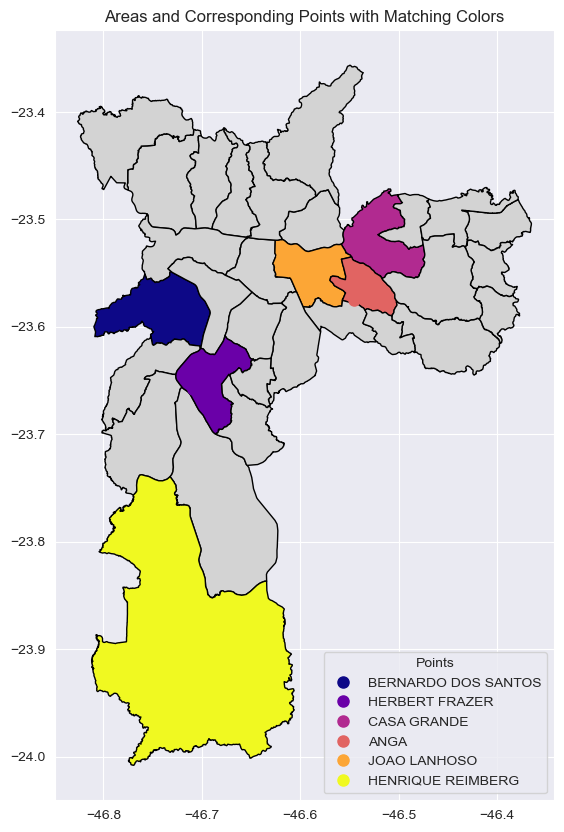

In [40]:

# Step 4: Mark areas that contain points and get the corresponding point index for each area
areas['point_index'] = points_in_areas['index_right']

# Step 5: Generate a colormap and assign colors based on point index
num_points = gdf_points.shape[0]
# Get the colormap using matplotlib.colormaps.get_cmap()
cmap = matplotlib.colormaps.get_cmap('plasma')  # Adjust the colormap as needed

# Generate colors for each point
colors = {i: cmap(i / (num_points - 1)) for i in range(num_points)}

# Step 6: Assign colors to areas based on the point they contain
areas['color'] = areas['point_index'].apply(lambda idx: colors[idx] if pd.notna(idx) else 'lightgray')

# Step 7: Plot the areas, coloring them based on the corresponding point color
fig, ax = plt.subplots(figsize=(10, 10))
areas.plot(ax=ax, color=areas['color'], edgecolor='black', legend=True)

# Step 8: Plot points with the same color as the areas
for i, row in gdf_points.iterrows():
    ax.plot(row.geometry.x, row.geometry.y, 'o', color=colors[i], markersize=8, label=row['name'])

# Customize legend (marker style, labels from DataFrame)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, loc='lower right', title="Points")

plt.title('Areas and Corresponding Points with Matching Colors')
plt.show()


In [41]:
import geopandas as gpd
from shapely.geometry import Point

def filter_points_in_area(shapefile_path, sp_nome, df, lat_col='latitude', lon_col='longitude'):
    # Load the shapefile
    areas = gpd.read_file(shapefile_path)

    # Filter the areas based on the specified sp_nome
    area_of_interest = areas[areas['sp_nome'] == sp_nome]

    if area_of_interest.empty:
        print(f"No area found with name: {sp_nome}")
        return pd.DataFrame()  # Return an empty DataFrame if no area is found

    # Convert the DataFrame to a GeoDataFrame
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf_points = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")  # Adjust CRS if necessary

    # Ensure the areas GeoDataFrame is in the same CRS as the points GeoDataFrame
    area_of_interest = area_of_interest.to_crs(gdf_points.crs)

    # Perform a spatial join to find points within the area of interest
    points_in_area = gpd.sjoin(gdf_points, area_of_interest, how='inner', predicate='within')

    return points_in_area

qwe_coord = filter_points_in_area('data/GIS_SP/SIRGAS_SHP_subprefeitura_polygon.shp', 'PARELHEIROS', df_tgt, lat_col='LAT', lon_col='LONG')
qwe_coord

,PDE,CODE_ENTIDADE,DESC_ENTIDADE,ATC,CEP,MUNICIPIO,TIPO_RUA,DESC_RUA,NUMERO_RUA,COORD_Y,...,Complemento,Status,geometry,index_right,sp_nome,sp_id,sp_codigo,sp_areakmt,sp_sigla,sp_areamt
1324,0771309449,1184,OSSI,929,04892140,SAO PAULO,RUA,CARLOS RASQUINHO,228.0,6990321.0,...,NaN,True,POINT (-46.699 -23.8478),19,PARELHEIROS,27.0,20,361.0,PA,360809940.0
1326,0184117119,1184,OSSI,929,04892190,SAO PAULO,RUA,MIGUEL ROCUMBACK,1.0,6979788.0,...,NaN,True,POINT (-46.698 -23.8485),19,PARELHEIROS,27.0,20,361.0,PA,360809940.0
1327,0183964616,1184,OSSI,929,04892140,SAO PAULO,RUA,CARLOS RASQUINHO,335.0,7126995.0,...,NaN,True,POINT (-46.7127 -23.8497),19,PARELHEIROS,27.0,20,361.0,PA,360809940.0
1328,0184114284,1184,OSSI,929,04892140,SAO PAULO,RUA,CARLOS RASQUINHO,156.0,6993179.0,...,NaN,True,POINT (-46.6993 -23.8478),19,PARELHEIROS,27.0,20,361.0,PA,360809940.0
1329,0695919970,1184,OSSI,929,04890740,SAO PAULO,RUA,JOSE RASQUINHO,100.0,70012654.0,...,NaN,True,POINT (-46.7001 -23.8496),19,PARELHEIROS,27.0,20,361.0,PA,360809940.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2607963,0249499223,1147,OOSB,928,05586070,SAO PAULO,PRACA,SANTO EPIFANIO,335.0,721956.0,...,NaN,True,POINT (-46.722 -23.7702),19,PARELHEIROS,27.0,20,361.0,PA,360809940.0
2607983,0249518031,1147,OOSB,928,05585010,SAO PAULO,RUA,BARROSO NETO,200.0,7219461.0,...,NaN,True,POINT (-46.7219 -23.7702),19,PARELHEIROS,27.0,20,361.0,PA,360809940.0
2608029,0249508826,1147,OOSB,928,05585040,SAO PAULO,RUA,JOSE PIRAGIBE,39.0,7219461.0,...,NaN,True,POINT (-46.7219 -23.7702),19,PARELHEIROS,27.0,20,361.0,PA,360809940.0
2608055,0249505134,1147,OOSB,928,05586060,SAO PAULO,RUA,CORINTO,558.0,72199684.0,...,NaN,True,POINT (-46.722 -23.7703),19,PARELHEIROS,27.0,20,361.0,PA,360809940.0


In [42]:
df_pare = df_tgt[df_tgt['PDE'].isin(qwe_coord['PDE'])]
df_pare.groupby(['DESC_RUA', 'NUMERO_RUA']).count()

PDE  CODE_ENTIDADE  DESC_ENTIDADE  ATC  \
DESC_RUA                  NUMERO_RUA                                           
ABADIA DOS DOURADOS       101.0         1              1              1    1   
ABILIO PEREIRA DE ALMEIDA 382.0         1              1              1    1   
ACAI                      8.0           1              1              1    1   
                          11.0          4              4              4    4   
ADRIANO RODRIGUEZ         25.0          1              1              1    1   
...                                   ...            ...            ...  ...   
XAVIER ALVARENGA          99.0          1              1              1    1   
                          128.0         2              2              2    2   
                          275.0         1              1              1    1   
                          280.0         1              1              1    1   
XINGU                     56.0          1              1              1    1   

                                      CEP  MUNICIPIO  TIPO_RUA  COORD_Y  LAT  \
DESC_RUA                  NUMERO_RUA                                           
ABADIA DOS DOURADOS       101.0         1          1         1        1    1   
ABILIO PEREIRA DE ALMEIDA 382.0         1          1         1        1    1   
ACAI                      8.0           1          1         1        1    1   
                          11.0          4          4         4        4    4   
ADRIANO RODRIGUEZ         25.0          1          1         1        1    1   
...                                   ...        ...       ...      ...  ...   
XAVIER ALVARENGA          99.0          1          1         1        1    1   
                          128.0         2          2         2        2    2   
                          275.0         1          1         1        1    1   
                          280.0         1          1         1        1    1   
XINGU                     56.0          1          1         1        1    1   

                                      LONG  Complemento  Status  
DESC_RUA                  NUMERO_RUA                             
ABADIA DOS DOURADOS       101.0          1            0       1  
ABILIO PEREIRA DE ALMEIDA 382.0          1            0       1  
ACAI                      8.0            1            1       1  
                          11.0           4            4       4  
ADRIANO RODRIGUEZ         25.0           1            0       1  
...                                    ...          ...     ...  
XAVIER ALVARENGA          99.0           1            0       1  
                          128.0          2            0       2  
                          275.0          1            0       1  
                          280.0          1            0       1  
XINGU                     56.0           1            0       1  

[13779 rows x 12 columns]

In [43]:
data_SP_checked[(data_SP_checked['DESC_RUA'] == 'ENEAS DE BARROS') &
                  (data_SP_checked['NUMERO_RUA'] == 769)]

,PDE,CODE_ENTIDADE,DESC_ENTIDADE,ATC,CEP,MUNICIPIO,TIPO_RUA,DESC_RUA,NUMERO_RUA,COORD_Y,LAT,LONG,Complemento,Status
937798,0729819388,1103,OLSM,921,03613000,SAO PAULO,RUA,ENEAS DE BARROS,769.0,53447.0,-23.5163,-46.5345,NaN,True
937818,0729817768,1103,OLSM,921,03613000,SAO PAULO,RUA,ENEAS DE BARROS,769.0,5343319.0,-23.5163,-46.5343,NaN,True
937835,0729820475,1103,OLSM,921,03613000,SAO PAULO,RUA,ENEAS DE BARROS,769.0,53450167.0,-23.5162,-46.5345,NaN,True
937883,0729826678,1103,OLSM,921,03613000,SAO PAULO,RUA,ENEAS DE BARROS,769.0,53438667.0,-23.5163,-46.5344,NaN,True
937890,0729825949,1103,OLSM,921,03613000,SAO PAULO,RUA,ENEAS DE BARROS,769.0,53442833.0,-23.5161,-46.5344,NaN,True
937893,0729828107,1103,OLSM,921,03613000,SAO PAULO,RUA,ENEAS DE BARROS,769.0,53438667.0,-23.5163,-46.5344,NaN,True
937900,0729822761,1103,OLSM,921,03613000,SAO PAULO,RUA,ENEAS DE BARROS,769.0,53442833.0,-23.5161,-46.5344,NaN,True
937941,0162962908,1103,OLSM,921,03613000,SAO PAULO,RUA,ENEAS DE BARROS,769.0,53578333.0,-23.5161,-46.5358,NaN,True
937950,0729815552,1103,OLSM,921,03613000,SAO PAULO,RUA,ENEAS DE BARROS,769.0,53450167.0,-23.5162,-46.5345,NaN,True
937951,0729823903,1103,OLSM,921,03613000,SAO PAULO,RUA,ENEAS DE BARROS,769.0,5343256.0,-23.5163,-46.5343,NaN,True


In [44]:
adress_dupl = data_SP_checked[(data_SP_checked['DESC_RUA'] == 'ENEAS DE BARROS') & (data_SP_checked['NUMERO_RUA'] == 769.0)][['PDE', 'CEP', 'DESC_RUA', 'NUMERO_RUA', 'LAT', 'LONG', 'Status']].copy()

# adress_dupl['LAT'] = np.round(adress_dupl['LAT'] / 0.0005) * 0.0005
# adress_dupl['LONG'] = np.round(adress_dupl['LONG'] / 0.0005) * 0.0005

print(f'Total de PDE único no mesmo endereço : {adress_dupl.shape[0]}')
adress_dupl.groupby(['CEP', 'DESC_RUA', 'NUMERO_RUA', 'LONG', 'LAT',  'Status']).count()['PDE']

Total de PDE único no mesmo endereço : 19


CEP       DESC_RUA         NUMERO_RUA  LONG      LAT       Status
03613000  ENEAS DE BARROS  769.0       -46.5358  -23.5161  True      2
                                       -46.5354  -23.5164  True      1
                                       -46.5349  -23.5161  True      1
                                       -46.5345  -23.5163  True      2
                                                 -23.5162  True      3
                                       -46.5344  -23.5163  True      2
                                                 -23.5162  True      2
                                                 -23.5161  True      3
                                       -46.5343  -23.5163  True      3
Name: PDE, dtype: int64

In [45]:
data_SP_round = data_SP_checked.copy()

# erros de 30m
round_val = 0.0002

data_SP_round['LAT'] = np.round(data_SP_round['LAT'] / round_val) * round_val
data_SP_round['LONG'] = np.round(data_SP_round['LONG'] / round_val) * round_val

adress_dupl = data_SP_round[(data_SP_round['DESC_RUA'] == 'ENEAS DE BARROS') & (data_SP_round['NUMERO_RUA'] == 769.0)][['PDE', 'CEP', 'DESC_RUA', 'NUMERO_RUA', 'LAT', 'LONG', 'Status']].copy()

print(f'Total de PDE único no mesmo endereço : {adress_dupl.shape[0]}')
adress_dupl.groupby(['CEP', 'DESC_RUA', 'NUMERO_RUA', 'LONG', 'LAT',  'Status']).count()['PDE']

Total de PDE único no mesmo endereço : 19


CEP       DESC_RUA         NUMERO_RUA  LONG      LAT       Status
03613000  ENEAS DE BARROS  769.0       -46.5358  -23.5160  True      2
                                       -46.5354  -23.5164  True      1
                                       -46.5348  -23.5160  True      1
                                       -46.5344  -23.5164  True      7
                                                 -23.5162  True      5
                                                 -23.5160  True      3
Name: PDE, dtype: int64

In [46]:
data_SP_checked

,PDE,CODE_ENTIDADE,DESC_ENTIDADE,ATC,CEP,MUNICIPIO,TIPO_RUA,DESC_RUA,NUMERO_RUA,COORD_Y,LAT,LONG,Complemento,Status
0,2000478360,1027,OCSM,919,03385100,SAO PAULO,RUA,LUIS MARIN DOS SANTOS,87.0,52511007.0,-23.5840,-46.5251,NaN,True
1,0746231849,1027,OCSM,919,03385060,SAO PAULO,RUA,LAZARO GONCALVES FRAGA,58.0,5254766.0,-23.5829,-46.5255,NaN,True
2,0929391632,1027,OCSM,919,03385050,SAO PAULO,RUA,SERAFIM DE ABREU,8.0,5258927.0,-23.5844,-46.5259,NaN,True
5,0806690267,1027,OCSM,919,03385090,SAO PAULO,RUA,AMATAXIRO,71.0,524366.0,-23.5834,-46.5244,NaN,True
6,0125047851,1027,OCSM,919,03385050,SAO PAULO,RUA,SERAFIM DE ABREU,79.0,5256699.0,-23.5840,-46.5257,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2616100,0597332096,1130,ONSP,918,05269030,SAO PAULO,RUA,DIEGO VELASQUEZ,393.0,789176.0,-23.4320,-46.7892,NaN,True
2616102,0629357048,1130,ONSP,918,05269040,SAO PAULO,RUA,FRANCISCO ALBANEZI,14.0,7899009.0,-23.4330,-46.7899,NaN,True
2616103,0751287130,1130,ONSP,918,05269030,SAO PAULO,RUA,DIEGO VELASQUEZ,230.0,7893561.0,-23.4322,-46.7894,NaN,True
2616104,0845902113,1130,ONSP,918,05269040,SAO PAULO,RUA,FRANCISCO ALBANEZI,78.0,7902075.0,-23.4321,-46.7902,NaN,True


In [47]:
# CSV pdes


cases_tgt = [{'rua': 'BERNARDO DOS SANTOS', 'numero': 10, 'CEP': '05542000'},
             {'rua': 'HERBERT FRAZER', 'numero': 963, 'CEP': '04815260'},
             {'rua': 'CASA GRANDE', 'numero': 900, 'CEP': '03260000'},
             {'rua': 'ANGA', 'numero': 896, 'CEP': '03360000'},
             {'rua': 'JOAO LANHOSO', 'numero': 241, 'CEP': '04240070'},
             {'rua': 'ENEAS DE BARROS', 'numero': 769, 'CEP': '03613000'},
             {'rua': 'HENRIQUE REIMBERG', 'numero': 1000, 'CEP': '04890610'}]
df_tgt = data_SP_checked

df_pdes = pd.DataFrame(columns = data_SP_checked.columns)

for case in cases_tgt:
    aux_tgt = df_tgt[(df_tgt['DESC_RUA'] == case['rua']) &
                     (df_tgt['NUMERO_RUA'] == case['numero'])]
    print(case['rua'], aux_tgt.shape)

    df_pdes = pd.concat([df_pdes, aux_tgt])
    
df_pdes

BERNARDO DOS SANTOS (646, 14)


C:\Users\arthu\AppData\Local\Temp\ipykernel_21484\1834462139.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pdes = pd.concat([df_pdes, aux_tgt])


HERBERT FRAZER (399, 14)
CASA GRANDE (397, 14)
ANGA (389, 14)
JOAO LANHOSO (322, 14)
ENEAS DE BARROS (19, 14)
HENRIQUE REIMBERG (18, 14)


,PDE,CODE_ENTIDADE,DESC_ENTIDADE,ATC,CEP,MUNICIPIO,TIPO_RUA,DESC_RUA,NUMERO_RUA,COORD_Y,LAT,LONG,Complemento,Status
566004,0859388239,1147,OOSB,928,05542000,SAO PAULO,RUA,BERNARDO DOS SANTOS,10.0,7289483.0,-23.5778,-46.7289,NaN,True
566005,0859814947,1147,OOSB,928,05542000,SAO PAULO,RUA,BERNARDO DOS SANTOS,10.0,7289483.0,-23.5778,-46.7289,NaN,True
566006,0859616983,1147,OOSB,928,05542000,SAO PAULO,RUA,BERNARDO DOS SANTOS,10.0,7289483.0,-23.5778,-46.7289,NaN,True
566007,0859441229,1147,OOSB,928,05542000,SAO PAULO,RUA,BERNARDO DOS SANTOS,10.0,7289483.0,-23.5778,-46.7289,NaN,True
566008,0858053004,1147,OOSB,928,05542000,SAO PAULO,RUA,BERNARDO DOS SANTOS,10.0,7289483.0,-23.5778,-46.7289,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150326,0921640307,1184,OSSI,929,04890610,SAO PAULO,RUA,HENRIQUE REIMBERG,1000.0,7121464.0,-23.8377,-46.7121,NaN,True
1150342,0921627386,1184,OSSI,929,04890610,SAO PAULO,RUA,HENRIQUE REIMBERG,1000.0,7121366.0,-23.8377,-46.7121,NaN,True
1150378,0921635567,1184,OSSI,929,04890610,SAO PAULO,RUA,HENRIQUE REIMBERG,1000.0,71215296.0,-23.8376,-46.7122,NaN,True
1150426,0921628510,1184,OSSI,929,04890610,SAO PAULO,RUA,HENRIQUE REIMBERG,1000.0,71219817.0,-23.8376,-46.7122,NaN,True


In [48]:
df_pdes.columns

Index(['PDE', 'CODE_ENTIDADE', 'DESC_ENTIDADE', 'ATC', 'CEP', 'MUNICIPIO',
       'TIPO_RUA', 'DESC_RUA', 'NUMERO_RUA', 'COORD_Y', 'LAT', 'LONG',
       'Complemento', 'Status'],
      dtype='object')

In [49]:
df_pdes.to_csv('results/pdes_consumo.csv', )

In [50]:
qwe = pd.read_csv('results/pdes_consumo.csv')
qwe

,Unnamed: 0,PDE,CODE_ENTIDADE,DESC_ENTIDADE,ATC,CEP,MUNICIPIO,TIPO_RUA,DESC_RUA,NUMERO_RUA,COORD_Y,LAT,LONG,Complemento,Status
0,566004,859388239,1147,OOSB,928,5542000,SAO PAULO,RUA,BERNARDO DOS SANTOS,10.0,7289483.0,-23.5778,-46.7289,NaN,True
1,566005,859814947,1147,OOSB,928,5542000,SAO PAULO,RUA,BERNARDO DOS SANTOS,10.0,7289483.0,-23.5778,-46.7289,NaN,True
2,566006,859616983,1147,OOSB,928,5542000,SAO PAULO,RUA,BERNARDO DOS SANTOS,10.0,7289483.0,-23.5778,-46.7289,NaN,True
3,566007,859441229,1147,OOSB,928,5542000,SAO PAULO,RUA,BERNARDO DOS SANTOS,10.0,7289483.0,-23.5778,-46.7289,NaN,True
4,566008,858053004,1147,OOSB,928,5542000,SAO PAULO,RUA,BERNARDO DOS SANTOS,10.0,7289483.0,-23.5778,-46.7289,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,1150326,921640307,1184,OSSI,929,4890610,SAO PAULO,RUA,HENRIQUE REIMBERG,1000.0,7121464.0,-23.8377,-46.7121,NaN,True
2186,1150342,921627386,1184,OSSI,929,4890610,SAO PAULO,RUA,HENRIQUE REIMBERG,1000.0,7121366.0,-23.8377,-46.7121,NaN,True
2187,1150378,921635567,1184,OSSI,929,4890610,SAO PAULO,RUA,HENRIQUE REIMBERG,1000.0,71215296.0,-23.8376,-46.7122,NaN,True
2188,1150426,921628510,1184,OSSI,929,4890610,SAO PAULO,RUA,HENRIQUE REIMBERG,1000.0,71219817.0,-23.8376,-46.7122,NaN,True


In [51]:
df_pdes

,PDE,CODE_ENTIDADE,DESC_ENTIDADE,ATC,CEP,MUNICIPIO,TIPO_RUA,DESC_RUA,NUMERO_RUA,COORD_Y,LAT,LONG,Complemento,Status
566004,0859388239,1147,OOSB,928,05542000,SAO PAULO,RUA,BERNARDO DOS SANTOS,10.0,7289483.0,-23.5778,-46.7289,NaN,True
566005,0859814947,1147,OOSB,928,05542000,SAO PAULO,RUA,BERNARDO DOS SANTOS,10.0,7289483.0,-23.5778,-46.7289,NaN,True
566006,0859616983,1147,OOSB,928,05542000,SAO PAULO,RUA,BERNARDO DOS SANTOS,10.0,7289483.0,-23.5778,-46.7289,NaN,True
566007,0859441229,1147,OOSB,928,05542000,SAO PAULO,RUA,BERNARDO DOS SANTOS,10.0,7289483.0,-23.5778,-46.7289,NaN,True
566008,0858053004,1147,OOSB,928,05542000,SAO PAULO,RUA,BERNARDO DOS SANTOS,10.0,7289483.0,-23.5778,-46.7289,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150326,0921640307,1184,OSSI,929,04890610,SAO PAULO,RUA,HENRIQUE REIMBERG,1000.0,7121464.0,-23.8377,-46.7121,NaN,True
1150342,0921627386,1184,OSSI,929,04890610,SAO PAULO,RUA,HENRIQUE REIMBERG,1000.0,7121366.0,-23.8377,-46.7121,NaN,True
1150378,0921635567,1184,OSSI,929,04890610,SAO PAULO,RUA,HENRIQUE REIMBERG,1000.0,71215296.0,-23.8376,-46.7122,NaN,True
1150426,0921628510,1184,OSSI,929,04890610,SAO PAULO,RUA,HENRIQUE REIMBERG,1000.0,71219817.0,-23.8376,-46.7122,NaN,True


In [52]:
df_as_strings = df_pdes.astype(str)
df_as_strings.to_csv('results/pdes_consumo.csv', index=False)

qwe = pd.read_csv('results/pdes_consumo.csv')
qwe

,PDE,CODE_ENTIDADE,DESC_ENTIDADE,ATC,CEP,MUNICIPIO,TIPO_RUA,DESC_RUA,NUMERO_RUA,COORD_Y,LAT,LONG,Complemento,Status
0,859388239,1147,OOSB,928,5542000,SAO PAULO,RUA,BERNARDO DOS SANTOS,10.0,7289483.0,-23.5778,-46.7289,NaN,True
1,859814947,1147,OOSB,928,5542000,SAO PAULO,RUA,BERNARDO DOS SANTOS,10.0,7289483.0,-23.5778,-46.7289,NaN,True
2,859616983,1147,OOSB,928,5542000,SAO PAULO,RUA,BERNARDO DOS SANTOS,10.0,7289483.0,-23.5778,-46.7289,NaN,True
3,859441229,1147,OOSB,928,5542000,SAO PAULO,RUA,BERNARDO DOS SANTOS,10.0,7289483.0,-23.5778,-46.7289,NaN,True
4,858053004,1147,OOSB,928,5542000,SAO PAULO,RUA,BERNARDO DOS SANTOS,10.0,7289483.0,-23.5778,-46.7289,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,921640307,1184,OSSI,929,4890610,SAO PAULO,RUA,HENRIQUE REIMBERG,1000.0,7121464.0,-23.8377,-46.7121,NaN,True
2186,921627386,1184,OSSI,929,4890610,SAO PAULO,RUA,HENRIQUE REIMBERG,1000.0,7121366.0,-23.8377,-46.7121,NaN,True
2187,921635567,1184,OSSI,929,4890610,SAO PAULO,RUA,HENRIQUE REIMBERG,1000.0,71215296.0,-23.8376,-46.7122,NaN,True
2188,921628510,1184,OSSI,929,4890610,SAO PAULO,RUA,HENRIQUE REIMBERG,1000.0,71219817.0,-23.8376,-46.7122,NaN,True
